In [12]:
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import math
from scipy import stats
from sklearn.linear_model import LinearRegression

def get_ranking_representations_in_order(dict):
    ranking_data = dict["ranking"]
    task_order = dict["treatmentOrder"]
    rankings_per_task = []
    for i in range(0,len(ranking_data)):
        if ranking_data[i]["category"] == "rankingRepresentation":
            rankings_per_task.append(ranking_data[i]["ranking"])
    sorted_rankings_by_task = [0] * 3;
    sorted_rankings_by_task[task_order[0]] = rankings_per_task[0]
    sorted_rankings_by_task[task_order[1]] = rankings_per_task[1]
    sorted_rankings_by_task[task_order[2]] = rankings_per_task[2]
    return sorted_rankings_by_task

def get_task_actions_in_order(dict):
    ranking_data = dict["ranking"]
    task_order = dict["treatmentOrder"]
    actions_per_task = []
    for i in range(0,len(ranking_data)):
        if ranking_data[i]["category"] == "rankingRepresentation":
            actions = []
            for j in range(i+1,len(ranking_data)):
                if ranking_data[j]["category"] == "serverEvent" or ranking_data[j]["category"] == "timeStamps":
                    i = j
                    break
                actions.append(ranking_data[j])
            actions_per_task.append(actions)
    sorted_actions_by_task = [0] * 3;
    sorted_actions_by_task[task_order[0]] = actions_per_task[0]
    sorted_actions_by_task[task_order[1]] = actions_per_task[1]
    sorted_actions_by_task[task_order[2]] = actions_per_task[2]
    return sorted_actions_by_task
        
def filter_for_choices(actions, ranking):
    selected_ids = []
    for action in actions:
        if action["eventName"] == "select":
            selected_ids.append(action["itemID"])
        if action["eventName"] == "unselect":
            selected_ids.remove(action["itemID"])
        if action["eventName"] == "fourthElementSelected":
            selected_ids.remove(action["itemID"])
    choices = []
    for id in selected_ids:
        for cand in ranking:
            try:
                if id == cand["id"]:
                    choices.append(cand)
            except:
                if id == cand[0]["id"]:
                    choices.append(cand[0])
                if id == cand[1]["id"]:
                    choices.append(cand[1])
    return choices

def get_survey_answers(dict):
    survey = dict["survey"]
    answers = []
    for entry in survey:
        if entry["category"] == "surveyQuestionAnswers":
            answers.append(entry)
    return answers

def load_data_as_df(path):
    path_to_jsonfiles = path
    cols = ['uID', 'ranking_type','briefing','task_order','task_1_ranking', 'task_2_ranking', 'task_3_ranking',
               'task_1_actions','task_2_actions','task_3_actions','task_1_choices','task_2_choices',
            'task_3_choices','survey_answers']
    data = pd.DataFrame(columns=cols)
    for file in os.listdir(path_to_jsonfiles):
        full_filename = "%s/%s" % (path_to_jsonfiles, file)
        with open(full_filename,'r') as fi:
            dict = json.load(fi)
            uID = file[0:len(file)-5]
            ranking_type = int(dict["ranking"][0]["itemID"])
            briefing = dict["briefing"]
            task_order = dict["treatmentOrder"]
            task_rankings = get_ranking_representations_in_order(dict)
            task_1_ranking = task_rankings[0]
            task_2_ranking = task_rankings[1]
            task_3_ranking = task_rankings[2]
            task_actions = get_task_actions_in_order(dict)
            task_1_actions = task_actions[0]
            task_2_actions = task_actions[1]
            task_3_actions = task_actions[2]
            task_1_choices = filter_for_choices(task_1_actions, task_1_ranking)
            task_2_choices = filter_for_choices(task_2_actions, task_2_ranking)
            task_3_choices = filter_for_choices(task_3_actions, task_3_ranking)
            survey_answers = get_survey_answers(dict)
            
            data = data.append({'uID': uID, 'ranking_type': ranking_type, 'briefing': briefing, 'task_order': task_order,
                               'task_1_ranking': task_1_ranking, 'task_2_ranking': task_2_ranking, 'task_3_ranking': task_3_ranking,
                               'task_1_actions': task_1_actions, 'task_2_actions': task_2_actions, 'task_3_actions': task_3_actions,
                               'task_1_choices': task_1_choices, 'task_2_choices': task_2_choices, 'task_3_choices': task_3_choices,
                               'survey_answers': survey_answers}, ignore_index=True)
    return data

def get_user_gender_age_income(survey_answers):
    for entry in survey_answers:
        if entry["category"] == "surveyQuestionAnswers" and entry["question"] == 5:
            return entry["answers"]
    return ["not available"] * 3

def get_ranked_candidates_experience_gender_rank_task_rankingtype(data_table):
    cols = ['total_xp','furniture_assembly_xp', 'home_repairs_xp', 'rank', 'task_nr', 'ranking_type', 'gender','uId'
            ,'uGender','uAge','uIncome']
    col_total = []
    col_furniture = []
    col_home = []
    col_rank = []
    col_task = []
    col_type = []
    col_gender = []
    col_uID = []
    col_uGender = []
    col_uAge = []
    col_uIncome = []
    for i in range(0, len(data_table.index)):
        for cand in data_table.iloc[i][4]:
            r_type = data_table.iloc[i][1]
            userDemographics = get_user_gender_age_income(data_table.iloc[i][13])
            uGender = userDemographics[0]
            uAge = userDemographics[1]
            uIncome = userDemographics[2]
            if r_type >= 4:
                for c in cand:
                    col_total.append(c["totalExp"])
                    col_furniture.append(c["tag1"])
                    col_home.append(c["tag2"])
                    col_rank.append(c["rank"])
                    col_task.append(1)
                    col_type.append(int(r_type))
                    col_uID.append(data_table.iloc[i][0])
                    col_uGender.append(uGender)
                    col_uAge.append(uAge)
                    col_uIncome.append(uIncome)
                    if c["gender"] == "f":
                        col_gender.append(0)
                    if c["gender"] == "m":
                        col_gender.append(1)
            else:
                col_total.append(cand["totalExp"])
                col_furniture.append(cand["tag1"])
                col_home.append(cand["tag2"])
                col_rank.append(cand["rank"])
                col_task.append(1)
                col_type.append(int(r_type))
                col_uID.append(data_table.iloc[i][0])
                col_uGender.append(uGender)
                col_uAge.append(uAge)
                col_uIncome.append(uIncome)
                if cand["gender"] == "f":
                    col_gender.append(0)
                if cand["gender"] == "m":
                    col_gender.append(1)
    for i in range(0, len(data_table.index)):
        for cand in data_table.iloc[i][5]:
            r_type = data_table.iloc[i][1]
            userDemographics = get_user_gender_age_income(data_table.iloc[i][13])
            uGender = userDemographics[0]
            uAge = userDemographics[1]
            uIncome = userDemographics[2]
            if r_type >= 4:
                for c in cand:
                    col_total.append(c["totalExp"])
                    col_furniture.append(c["tag1"])
                    col_home.append(c["tag2"])
                    col_rank.append(c["rank"])
                    col_task.append(2)
                    col_type.append(int(r_type))
                    col_uID.append(data_table.iloc[i][0])
                    col_uGender.append(uGender)
                    col_uAge.append(uAge)
                    col_uIncome.append(uIncome)
                    if c["gender"] == "f":
                        col_gender.append(0)
                    if c["gender"] == "m":
                        col_gender.append(1)
            else:
                col_total.append(cand["totalExp"])
                col_furniture.append(cand["tag1"])
                col_home.append(cand["tag2"])
                col_rank.append(cand["rank"])
                col_task.append(2)
                col_type.append(int(r_type))
                col_uID.append(data_table.iloc[i][0])
                col_uGender.append(uGender)
                col_uAge.append(uAge)
                col_uIncome.append(uIncome)
                if cand["gender"] == "f":
                    col_gender.append(0)
                if cand["gender"] == "m":
                    col_gender.append(1)
    for i in range(0, len(data_table.index)):
        for cand in data_table.iloc[i][6]:
            r_type = data_table.iloc[i][1]
            userDemographics = get_user_gender_age_income(data_table.iloc[i][13])
            uGender = userDemographics[0]
            uAge = userDemographics[1]
            uIncome = userDemographics[2]
            if r_type >= 4:
                for c in cand:
                    col_total.append(c["totalExp"])
                    col_furniture.append(c["tag1"])
                    col_home.append(c["tag2"])
                    col_rank.append(c["rank"])
                    col_task.append(3)
                    col_type.append(int(r_type))
                    col_uID.append(data_table.iloc[i][0])
                    col_uGender.append(uGender)
                    col_uAge.append(uAge)
                    col_uIncome.append(uIncome)
                    if c["gender"] == "f":
                        col_gender.append(0)
                    if c["gender"] == "m":
                        col_gender.append(1)
            else:
                col_total.append(cand["totalExp"])
                col_furniture.append(cand["tag1"])
                col_home.append(cand["tag2"])
                col_rank.append(cand["rank"])
                col_task.append(3)
                col_type.append(int(r_type))
                col_uID.append(data_table.iloc[i][0])
                col_uGender.append(uGender)
                col_uAge.append(uAge)
                col_uIncome.append(uIncome)
                if cand["gender"] == "f":
                    col_gender.append(0)
                if cand["gender"] == "m":
                    col_gender.append(1)
    allArr = [col_total, col_furniture, col_home, col_rank, col_task, col_type, col_gender, col_uID, col_uGender, col_uAge, col_uIncome]
    selected = []
    for i in range(0,len(col_total)):
        cand = []
        for j in range(0,len(allArr)):
            cand.append(allArr[j][i])
        selected.append(cand)
    data = data = pd.DataFrame(np.array(selected), columns=cols)
    cols = ['total_xp','furniture_assembly_xp', 'home_repairs_xp', 'rank', 'task_nr', 'ranking_type', 'gender','uId', 'uGender', 'uAge', 'uIncome']
    data["total_xp"] = data["total_xp"].astype(float)
    data["furniture_assembly_xp"] = data["furniture_assembly_xp"].astype(float)
    data["home_repairs_xp"] = data["home_repairs_xp"].astype(float)
    data["rank"] = data["rank"].astype(int)
    data["task_nr"] = data["task_nr"].astype(int)
    data["ranking_type"] = data["ranking_type"].astype(int)
    data["gender"] = data["gender"].astype(int)
    return data

    
        
def get_selected_candidates_experience_gender_rank_task_rankingtype(data_table):
    #gender == 0 ->f
    #gender == 1 ->m
    cols = ['total_xp','furniture_assembly_xp', 'home_repairs_xp', 'rank', 'task_nr', 'ranking_type', 'gender','uId', 'uGender', 'uAge', 'uIncome']
    col_total = []
    col_furniture = []
    col_home = []
    col_rank = []
    col_task = []
    col_type = []
    col_gender = []
    col_uID = []
    col_uGender = []
    col_uAge = []
    col_uIncome = []
    for i in range(0, len(data_table.index)):
        userDemographics = get_user_gender_age_income(data_table.iloc[i][13])
        uGender = userDemographics[0]
        uAge = userDemographics[1]
        uIncome = userDemographics[2]
        for cand in data_table.iloc[i][10]:
            col_total.append(cand["totalExp"])
            col_furniture.append(cand["tag1"])
            col_home.append(cand["tag2"])
            col_rank.append(cand["rank"])
            col_task.append(1)
            r_type = data_table.iloc[i][1]
            col_type.append(int(r_type))
            col_uID.append(data_table.iloc[i][0])
            col_uGender.append(uGender)
            col_uAge.append(uAge)
            col_uIncome.append(uIncome)
            if cand["gender"] == "f":
                col_gender.append(0)
            if cand["gender"] == "m":
                col_gender.append(1)
    for i in range(0, len(data_table.index)):
        userDemographics = get_user_gender_age_income(data_table.iloc[i][13])
        uGender = userDemographics[0]
        uAge = userDemographics[1]
        uIncome = userDemographics[2]
        for cand in data_table.iloc[i][11]:
            col_total.append(cand["totalExp"])
            col_furniture.append(cand["tag1"])
            col_home.append(cand["tag2"])
            col_rank.append(cand["rank"])
            col_task.append(2)
            r_type = data_table.iloc[i][1]
            col_type.append(int(r_type))
            col_uID.append(data_table.iloc[i][0])
            col_uGender.append(uGender)
            col_uAge.append(uAge)
            col_uIncome.append(uIncome)
            if cand["gender"] == "f":
                col_gender.append(0)
            if cand["gender"] == "m":
                col_gender.append(1)
    for i in range(0, len(data_table.index)):
        userDemographics = get_user_gender_age_income(data_table.iloc[i][13])
        uGender = userDemographics[0]
        uAge = userDemographics[1]
        uIncome = userDemographics[2]
        for cand in data_table.iloc[i][12]:
            col_total.append(cand["totalExp"])
            col_furniture.append(cand["tag1"])
            col_home.append(cand["tag2"])
            col_rank.append(cand["rank"])
            col_task.append(3)
            r_type = data_table.iloc[i][1]
            col_type.append(int(r_type))
            col_uID.append(data_table.iloc[i][0])
            col_uGender.append(uGender)
            col_uAge.append(uAge)
            col_uIncome.append(uIncome)
            if cand["gender"] == "f":
                col_gender.append(0)
            if cand["gender"] == "m":
                col_gender.append(1)
    allArr = [col_total, col_furniture, col_home, col_rank, col_task, col_type, col_gender, col_uID, col_uGender, col_uAge, col_uIncome]
    selected = []
    for i in range(0,len(col_total)):
        cand = []
        for j in range(0,len(allArr)):
            cand.append(allArr[j][i])
        selected.append(cand)
    data = data = pd.DataFrame(np.array(selected), columns=cols)
    cols = ['total_xp','furniture_assembly_xp', 'home_repairs_xp', 'rank', 'task_nr', 'ranking_type', 'gender','uId', 'uGender', 'uAge', 'uIncome']
    data["total_xp"] = data["total_xp"].astype(float)
    data["furniture_assembly_xp"] = data["furniture_assembly_xp"].astype(float)
    data["home_repairs_xp"] = data["home_repairs_xp"].astype(float)
    data["rank"] = data["rank"].astype(int)
    data["task_nr"] = data["task_nr"].astype(int)
    data["ranking_type"] = data["ranking_type"].astype(int)
    data["gender"] = data["gender"].astype(int)
    return data
    
def get_probability_distribution_single_rankings_as_array(data="all", task="all", rankingTypes_ordered=[2,3], rankingTypes_not_ordered= [0,1]
                             , xp_used="total", xp_cutoff = 12, prefix="test", uGender="all", uIncome="all", uAge="all"):
    if data=="all":
        path = "./all_test_data"
    else:
        path = "./jsonFiles_valid_third_test"
    
    data_task_start = 4
    data_task_end = 7
    suffix1 = "allTasks"
    if task == "furniture assembly":
        task_nr = 1
        data_task_start = 4
        data_task_end = 5
        suffix1 = "TaskFurnitureAssembly"
    if task == "home repairs":
        task_nr = 2
        data_task_start = 5
        data_task_end = 6
        suffix1 = "TaskHomeRepairs"
    if task == "furniture delivery":
        task_nr = 3
        data_task_start = 6
        data_task_end = 7
        suffix1 = "TaskFurnitureDelivery"
    
    xp_used_field = "totalExp"
    xp_used_index = 0
    suffix2 = "totalExp"
    if xp_used == "furniture":
        xp_used_field = "tag1"
        xp_used_index = 1
        suffix2 = "FurnitureAssemblyExp"
    if xp_used == "home":
        xp_used_field = "tag2"
        xp_used_index = 2
        suffix2 = "HomeRepairsExp"
        
    
    #Ordered Rankings
    data = load_data_as_df(path)
    #data = data[(data['ranking_type'].isin(rankingTypes_ordered))]
    seen_data_ordered = get_ranked_candidates_experience_gender_rank_task_rankingtype(data)
    seen_data_ordered = seen_data_ordered[(seen_data_ordered['ranking_type'].isin(rankingTypes_ordered))]
    if task != "all":
        seen_data_ordered = seen_data_ordered[(seen_data_ordered['task_nr']==task_nr)]
    if uGender != "all":
        seen_data_ordered = seen_data_ordered[(seen_data_ordered['uGender'] == uGender)]
    if uIncome != "all":
        seen_data_ordered = seen_data_ordered[(seen_data_ordered['uIncome'] == uIncome)]
    if uAge != "all":
        seen_data_ordered = seen_data_ordered[(seen_data_ordered['uAge'] == uAge)]
    seen_candidates_per_rank = [0]*20
    for i in range(0,20):
        seen_candidates_per_rank[i] = []
    for i in range(0,len(seen_data_ordered.index)):
        rank = seen_data_ordered.iloc[i][3]
        total_xp = seen_data_ordered.iloc[i][xp_used_index]
        if seen_data_ordered.iloc[i][6] == 0:
            gender = 'f'
        else:
            gender = 'm'
        seen_candidates_per_rank[rank-1].append((total_xp,gender))

    
    #Random Rankings
    data = load_data_as_df(path)
    #data = data[(data['ranking_type'].isin(rankingTypes_not_ordered))]
    seen_data_unordered = get_ranked_candidates_experience_gender_rank_task_rankingtype(data)
    seen_data_unordered = seen_data_unordered[(seen_data_unordered['ranking_type'].isin(rankingTypes_not_ordered))]
    if task != "all":
        seen_data_unordered = seen_data_unordered[(seen_data_unordered['task_nr']==task_nr)]
    if uGender != "all":
        seen_data_unordered = seen_data_unordered[(seen_data_unordered['uGender'] == uGender)]
    if uIncome != "all":
        seen_data_unordered = seen_data_unordered[(seen_data_unordered['uIncome'] == uIncome)]
    if uAge != "all":
        seen_data_unordered = seen_data_unordered[(seen_data_unordered['uAge'] == uAge)]
    for i in range(0,len(seen_data_unordered.index)):
        rank = seen_data_unordered.iloc[i][3]
        total_xp = seen_data_unordered.iloc[i][xp_used_index]
        if seen_data_unordered.iloc[i][6] == 0:
            gender = 'f'
        else:
            gender = 'm'
        seen_candidates_per_rank[rank-1].append((total_xp,gender))
    #Side by Side Rankings
    
    data = load_data_as_df(path)
    plot_data = get_selected_candidates_experience_gender_rank_task_rankingtype(data)
    plot_data = plot_data[(plot_data['ranking_type'].isin(rankingTypes_ordered+rankingTypes_not_ordered))]
    if uGender != "all":
        plot_data = plot_data[(plot_data['uGender'] == uGender)]
    if task != "all":
        plot_data = plot_data[(plot_data['task_nr'] == task_nr)]
    if uIncome != "all":
        plot_data = plot_data[(plot_data['uIncome'] == uIncome)]
    if uAge != "all":
        plot_data = plot_data[(plot_data['uAge'] == uAge)]
    selected_candidates_per_rank = [0]*20
    #print("n = "+str(len(plot_data)))
    for i in range(0,20):
        selected_candidates_per_rank[i] = []
    for i in range(0,len(plot_data.index)):
        rank = plot_data.iloc[i][3]
        total_xp = plot_data.iloc[i][xp_used_index]
        if plot_data.iloc[i][6] == 0:
            gender = 'f'
        else:
            gender = 'm'
        selected_candidates_per_rank[rank-1].append((total_xp,gender))

    distribution_data = {}
    
    distribution_overall = [0]*20
    for i in range(0,len(selected_candidates_per_rank)):
        distribution_overall[i]=len(selected_candidates_per_rank[i])/max(1,len(seen_candidates_per_rank[i]))
    
    distribution_data["overall"] = {}
    distribution_data["overall"]["seen"] = seen_candidates_per_rank
    distribution_data["overall"]["selected"] = selected_candidates_per_rank
    distribution_data["overall"]["overall"] = distribution_overall
    
    seen_female_candidates_per_rank = [0]*20
    selected_female_candidates_per_rank = [0]*20
    female_distribution_overall = [0]*20
    for i in range(0,20):
        seen_female_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if cand[1] == 'f']
        selected_female_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if cand[1] == 'f']
    for i in range(0,len(selected_female_candidates_per_rank)):
        female_distribution_overall[i]=len(selected_female_candidates_per_rank[i])/max(1,len(seen_female_candidates_per_rank[i]))

    distribution_data["female"] = {}
    distribution_data["female"]["seen"] = seen_female_candidates_per_rank
    distribution_data["female"]["selected"] = selected_female_candidates_per_rank
    distribution_data["female"]["overall"] = female_distribution_overall    
    
    seen_male_candidates_per_rank = [0]*20
    selected_male_candidates_per_rank = [0]*20
    male_distribution_overall = [0]*20
    for i in range(0,20):
        seen_male_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if cand[1] == 'm']
        selected_male_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if cand[1] == 'm']
    for i in range(0,len(selected_male_candidates_per_rank)):
        male_distribution_overall[i]=len(selected_male_candidates_per_rank[i])/max(1,len(seen_male_candidates_per_rank[i]))   
    
    distribution_data["male"] = {}
    distribution_data["male"]["seen"] = seen_male_candidates_per_rank
    distribution_data["male"]["selected"] = selected_male_candidates_per_rank
    distribution_data["male"]["overall"] = male_distribution_overall  
    
    seen_female_low_xp_candidates_per_rank = [0]*20
    selected_female_low_xp_candidates_per_rank = [0]*20
    female_low_xp_distribution_overall = [0]*20
    for i in range(0,20):
        seen_female_low_xp_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if (cand[1] == 'f' and cand[0] <xp_cutoff)]
        selected_female_low_xp_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if (cand[1] == 'f' and cand[0] <xp_cutoff)]
    for i in range(0,len(selected_female_candidates_per_rank)):
        female_low_xp_distribution_overall[i]=len(selected_female_low_xp_candidates_per_rank[i])/max(1,len(seen_female_low_xp_candidates_per_rank[i]))
    
    distribution_data["female_low"] = {}
    distribution_data["female_low"]["seen"] = seen_female_low_xp_candidates_per_rank
    distribution_data["female_low"]["selected"] = selected_female_low_xp_candidates_per_rank
    distribution_data["female_low"]["overall"] = female_low_xp_distribution_overall  
    
    seen_male_low_xp_candidates_per_rank = [0]*20
    selected_male_low_xp_candidates_per_rank = [0]*20
    male_low_xp_distribution_overall = [0]*20
    for i in range(0,20):
        seen_male_low_xp_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if (cand[1] == 'm' and cand[0] <xp_cutoff)]
        selected_male_low_xp_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if (cand[1] == 'm' and cand[0] <xp_cutoff)]
    for i in range(0,len(selected_male_candidates_per_rank)):
        male_low_xp_distribution_overall[i]=len(selected_male_low_xp_candidates_per_rank[i])/max(1,len(seen_male_low_xp_candidates_per_rank[i]))
    
    distribution_data["male_low"] = {}
    distribution_data["male_low"]["seen"] = seen_male_low_xp_candidates_per_rank
    distribution_data["male_low"]["selected"] = selected_male_low_xp_candidates_per_rank
    distribution_data["male_low"]["overall"] = male_low_xp_distribution_overall  
    
    seen_female_high_xp_candidates_per_rank = [0]*20
    selected_female_high_xp_candidates_per_rank = [0]*20
    female_high_xp_distribution_overall = [0]*20
    for i in range(0,20):
        seen_female_high_xp_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if (cand[1] == 'f' and cand[0] >=xp_cutoff)]
        selected_female_high_xp_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if (cand[1] == 'f' and cand[0] >=xp_cutoff)]
    for i in range(0,len(selected_female_candidates_per_rank)):
        female_high_xp_distribution_overall[i]=len(selected_female_high_xp_candidates_per_rank[i])/max(1,len(seen_female_high_xp_candidates_per_rank[i]))

    distribution_data["female_high"] = {}
    distribution_data["female_high"]["seen"] = seen_female_high_xp_candidates_per_rank
    distribution_data["female_high"]["selected"] = selected_female_high_xp_candidates_per_rank
    distribution_data["female_high"]["overall"] = female_high_xp_distribution_overall  
        
    seen_male_high_xp_candidates_per_rank = [1]*20
    selected_male_high_xp_candidates_per_rank = [0]*20
    male_high_xp_distribution_overall = [0]*20
    for i in range(0,20):
        seen_male_high_xp_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if (cand[1] == 'm' and cand[0] >=xp_cutoff)]
        selected_male_high_xp_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if (cand[1] == 'm' and cand[0] >=xp_cutoff)]
    for i in range(0,len(selected_male_candidates_per_rank)):
        male_high_xp_distribution_overall[i]=len(selected_male_high_xp_candidates_per_rank[i])/max(1,len(seen_male_high_xp_candidates_per_rank[i]))

    distribution_data["male_high"] = {}
    distribution_data["male_high"]["seen"] = seen_male_high_xp_candidates_per_rank
    distribution_data["male_high"]["selected"] = selected_male_high_xp_candidates_per_rank
    distribution_data["male_high"]["overall"] = male_high_xp_distribution_overall
        
    return distribution_data

def get_probability_distribution_double_rankings_as_array(data="all", task="all", rankingTypes=[4,5,6,7]
                             , xp_used="total", xp_cutoff = 12, prefix="test", uGender="all", uIncome="all", uAge="all"):
    if data=="all":
        path = "./all_test_data"
    else:
        path = "./jsonFiles_valid_third_test"
    
    data_task_start = 4
    data_task_end = 7
    suffix1 = "allTasks"
    if task == "furniture assembly":
        task_nr = 1
        data_task_start = 4
        data_task_end = 5
        suffix1 = "TaskFurnitureAssembly"
    if task == "home repairs":
        task_nr = 2
        data_task_start = 5
        data_task_end = 6
        suffix1 = "TaskHomeRepairs"
    if task == "furniture delivery":
        task_nr = 3
        data_task_start = 6
        data_task_end = 7
        suffix1 = "TaskFurnitureDelivery"
    
    xp_used_field = "totalExp"
    xp_used_index = 0
    suffix2 = "totalExp"
    if xp_used == "furniture":
        xp_used_field = "tag1"
        xp_used_index = 1
        suffix2 = "FurnitureAssemblyExp"
    if xp_used == "home":
        xp_used_field = "tag2"
        xp_used_index = 2
        suffix2 = "HomeRepairsExp"
        
    data = load_data_as_df(path)
    seen_data_ordered = get_ranked_candidates_experience_gender_rank_task_rankingtype(data)
    seen_data_ordered = seen_data_ordered[(seen_data_ordered['ranking_type'].isin(rankingTypes))]
    if task != "all":
        seen_data_ordered = seen_data_ordered[(seen_data_ordered['task_nr']==task_nr)]
    if uGender != "all":
        seen_data_ordered = seen_data_ordered[(seen_data_ordered['uGender'] == uGender)]
    if uIncome != "all":
        seen_data_ordered = seen_data_ordered[(seen_data_ordered['uIncome'] == uIncome)]
    if uAge != "all":
        seen_data_ordered = seen_data_ordered[(seen_data_ordered['uAge'] == uAge)]
    seen_candidates_per_rank = [0]*10
    for i in range(0,10):
        seen_candidates_per_rank[i] = []
    for i in range(0,len(seen_data_ordered.index)):
        rank = seen_data_ordered.iloc[i][3]
        total_xp = seen_data_ordered.iloc[i][xp_used_index]
        if seen_data_ordered.iloc[i][6] == 0:
            gender = 'f'
        else:
            gender = 'm'
        seen_candidates_per_rank[rank-1].append((total_xp,gender))
    
    data = load_data_as_df(path)
    plot_data = get_selected_candidates_experience_gender_rank_task_rankingtype(data)
    plot_data = plot_data[(plot_data['ranking_type'].isin(rankingTypes))]
    if uGender != "all":
        plot_data = plot_data[(plot_data['uGender'] == uGender)]
    if task != "all":
        plot_data = plot_data[(plot_data['task_nr'] == task_nr)]
    if uIncome != "all":
        plot_data = plot_data[(plot_data['uIncome'] == uIncome)]
    if uAge != "all":
        plot_data = plot_data[(plot_data['uAge'] == uAge)]
    selected_candidates_per_rank = [0]*10
    #print("n = "+str(len(plot_data)))
    for i in range(0,10):
        selected_candidates_per_rank[i] = []
    for i in range(0,len(plot_data.index)):
        rank = plot_data.iloc[i][3]
        total_xp = plot_data.iloc[i][xp_used_index]
        if plot_data.iloc[i][6] == 0:
            gender = 'f'
        else:
            gender = 'm'
        selected_candidates_per_rank[rank-1].append((total_xp,gender))

    distribution_data = {}
    
    distribution_overall = [0]*10
    for i in range(0,len(selected_candidates_per_rank)):
        distribution_overall[i]=len(selected_candidates_per_rank[i])/max(1,len(seen_candidates_per_rank[i]))
    
    distribution_data["overall"] = {}
    distribution_data["overall"]["seen"] = seen_candidates_per_rank
    distribution_data["overall"]["selected"] = selected_candidates_per_rank
    distribution_data["overall"]["overall"] = distribution_overall
    
    seen_female_candidates_per_rank = [0]*10
    selected_female_candidates_per_rank = [0]*10
    female_distribution_overall = [0]*10
    for i in range(0,10):
        seen_female_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if cand[1] == 'f']
        selected_female_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if cand[1] == 'f']
    for i in range(0,len(selected_female_candidates_per_rank)):
        female_distribution_overall[i]=len(selected_female_candidates_per_rank[i])/max(1,len(seen_female_candidates_per_rank[i]))

    distribution_data["female"] = {}
    distribution_data["female"]["seen"] = seen_female_candidates_per_rank
    distribution_data["female"]["selected"] = selected_female_candidates_per_rank
    distribution_data["female"]["overall"] = female_distribution_overall    
    
    seen_male_candidates_per_rank = [0]*10
    selected_male_candidates_per_rank = [0]*10
    male_distribution_overall = [0]*10
    for i in range(0,10):
        seen_male_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if cand[1] == 'm']
        selected_male_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if cand[1] == 'm']
    for i in range(0,len(selected_male_candidates_per_rank)):
        male_distribution_overall[i]=len(selected_male_candidates_per_rank[i])/max(1,len(seen_male_candidates_per_rank[i]))   
    
    distribution_data["male"] = {}
    distribution_data["male"]["seen"] = seen_male_candidates_per_rank
    distribution_data["male"]["selected"] = selected_male_candidates_per_rank
    distribution_data["male"]["overall"] = male_distribution_overall  
    
    seen_female_low_xp_candidates_per_rank = [0]*10
    selected_female_low_xp_candidates_per_rank = [0]*10
    female_low_xp_distribution_overall = [0]*10
    for i in range(0,10):
        seen_female_low_xp_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if (cand[1] == 'f' and cand[0] <xp_cutoff)]
        selected_female_low_xp_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if (cand[1] == 'f' and cand[0] <xp_cutoff)]
    for i in range(0,len(selected_female_candidates_per_rank)):
        female_low_xp_distribution_overall[i]=len(selected_female_low_xp_candidates_per_rank[i])/max(1,len(seen_female_low_xp_candidates_per_rank[i]))
    
    distribution_data["female_low"] = {}
    distribution_data["female_low"]["seen"] = seen_female_low_xp_candidates_per_rank
    distribution_data["female_low"]["selected"] = selected_female_low_xp_candidates_per_rank
    distribution_data["female_low"]["overall"] = female_low_xp_distribution_overall  
    
    seen_male_low_xp_candidates_per_rank = [0]*10
    selected_male_low_xp_candidates_per_rank = [0]*10
    male_low_xp_distribution_overall = [0]*10
    for i in range(0,10):
        seen_male_low_xp_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if (cand[1] == 'm' and cand[0] <xp_cutoff)]
        selected_male_low_xp_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if (cand[1] == 'm' and cand[0] <xp_cutoff)]
    for i in range(0,len(selected_male_candidates_per_rank)):
        male_low_xp_distribution_overall[i]=len(selected_male_low_xp_candidates_per_rank[i])/max(1,len(seen_male_low_xp_candidates_per_rank[i]))
    
    distribution_data["male_low"] = {}
    distribution_data["male_low"]["seen"] = seen_male_low_xp_candidates_per_rank
    distribution_data["male_low"]["selected"] = selected_male_low_xp_candidates_per_rank
    distribution_data["male_low"]["overall"] = male_low_xp_distribution_overall  
    
    seen_female_high_xp_candidates_per_rank = [0]*10
    selected_female_high_xp_candidates_per_rank = [0]*10
    female_high_xp_distribution_overall = [0]*10
    for i in range(0,10):
        seen_female_high_xp_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if (cand[1] == 'f' and cand[0] >=xp_cutoff)]
        selected_female_high_xp_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if (cand[1] == 'f' and cand[0] >=xp_cutoff)]
    for i in range(0,len(selected_female_candidates_per_rank)):
        female_high_xp_distribution_overall[i]=len(selected_female_high_xp_candidates_per_rank[i])/max(1,len(seen_female_high_xp_candidates_per_rank[i]))

    distribution_data["female_high"] = {}
    distribution_data["female_high"]["seen"] = seen_female_high_xp_candidates_per_rank
    distribution_data["female_high"]["selected"] = selected_female_high_xp_candidates_per_rank
    distribution_data["female_high"]["overall"] = female_high_xp_distribution_overall  
        
    seen_male_high_xp_candidates_per_rank = [0]*10
    selected_male_high_xp_candidates_per_rank = [0]*10
    male_high_xp_distribution_overall = [0]*10
    for i in range(0,10):
        seen_male_high_xp_candidates_per_rank[i] = [cand for cand in seen_candidates_per_rank[i] if (cand[1] == 'm' and cand[0] >=xp_cutoff)]
        selected_male_high_xp_candidates_per_rank[i] = [cand for cand in selected_candidates_per_rank[i] if (cand[1] == 'm' and cand[0] >=xp_cutoff)]
    for i in range(0,len(selected_male_candidates_per_rank)):
        male_high_xp_distribution_overall[i]=len(selected_male_high_xp_candidates_per_rank[i])/max(1,len(seen_male_high_xp_candidates_per_rank[i]))

    distribution_data["male_high"] = {}
    distribution_data["male_high"]["seen"] = seen_male_high_xp_candidates_per_rank
    distribution_data["male_high"]["selected"] = selected_male_high_xp_candidates_per_rank
    distribution_data["male_high"]["overall"] = male_high_xp_distribution_overall
        
    return distribution_data

def plot_probs_single_ranking(tag, data="all", task="all", rankingTypes_ordered=[2,3], rankingTypes_not_ordered= [0,1]
                             , xp_used="total", xp_cutoff = 12, prefix="test", uGender="all", uIncome="all", uAge="all"):
    
    data = get_probability_distribution_single_rankings_as_array(data = data, task=task, rankingTypes_ordered = rankingTypes_ordered,
                                                                rankingTypes_not_ordered = rankingTypes_not_ordered,
                                                                xp_used = xp_used, xp_cutoff= xp_cutoff, prefix = prefix,
                                                                uGender=uGender,uIncome = uIncome, uAge= uAge)
    seen_male_candidates_rank_1_to_3 = 0
    seen_male_candidates_rank_4_to_6 = 0
    seen_male_candidates_rank_7_to_9 = 0
    seen_male_candidates_rank_10_to_12 = 0
    seen_male_candidates_rank_13_to_15 = 0
    seen_male_candidates_rank_16_to_20 = 0
    
    seen_female_candidates_rank_1_to_3 = 0
    seen_female_candidates_rank_4_to_6 = 0
    seen_female_candidates_rank_7_to_9 = 0
    seen_female_candidates_rank_10_to_12 = 0
    seen_female_candidates_rank_13_to_15 = 0
    seen_female_candidates_rank_16_to_20 = 0
    
    selected_male_candidates_rank_1_to_3 = 0
    selected_male_candidates_rank_4_to_6 = 0
    selected_male_candidates_rank_7_to_9 = 0
    selected_male_candidates_rank_10_to_12 = 0
    selected_male_candidates_rank_13_to_15 = 0
    selected_male_candidates_rank_16_to_20 = 0
    
    selected_female_candidates_rank_1_to_3 = 0
    selected_female_candidates_rank_4_to_6 = 0
    selected_female_candidates_rank_7_to_9 = 0
    selected_female_candidates_rank_10_to_12 = 0
    selected_female_candidates_rank_13_to_15 = 0
    selected_female_candidates_rank_16_to_20 = 0
    log_1_to_3 = 0
    log_4_to_6 = 0
    log_7_to_9 = 0
    log_10_to_12 = 0
    log_13_to_15 = 0
    log_16_to_20 = 0
    overall_seen_1_to_3 = 0
    overall_seen_4_to_6 = 0
    overall_seen_7_to_9 = 0
    overall_seen_10_to_12 = 0
    overall_seen_13_to_15 = 0
    overall_seen_16_to_20 = 0
    for i in range(0,3):
        selected_male_candidates_rank_1_to_3 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_1_to_3 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_1_to_3 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_1_to_3 += len(data["female"+tag]["seen"][i])
        #log_1_to_3 += (1.0/math.log(i+2,2))
        overall_seen_1_to_3 += len(data["overall"]["seen"][i])
        log_1_to_3 += data["overall"]["overall"][i]
    for i in range(3,6):
        overall_seen_4_to_6 += len(data["overall"]["seen"][i])
        selected_male_candidates_rank_4_to_6 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_4_to_6 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_4_to_6 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_4_to_6 += len(data["female"+tag]["seen"][i])
        log_4_to_6 += data["overall"]["overall"][i]
    for i in range(6,9):
        overall_seen_7_to_9 += len(data["overall"]["seen"][i])
        selected_male_candidates_rank_7_to_9 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_7_to_9 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_7_to_9 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_7_to_9 += len(data["female"+tag]["seen"][i])
        log_7_to_9 += data["overall"]["overall"][i]
    for i in range(9,12):
        overall_seen_10_to_12 += len(data["overall"]["seen"][i])
        selected_male_candidates_rank_10_to_12 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_10_to_12 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_10_to_12 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_10_to_12 += len(data["female"+tag]["seen"][i])
        log_10_to_12 += data["overall"]["overall"][i]
    for i in range(12,15):
        overall_seen_13_to_15 += len(data["overall"]["seen"][i])
        selected_male_candidates_rank_13_to_15 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_13_to_15 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_13_to_15 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_13_to_15 += len(data["female"+tag]["seen"][i])
        log_13_to_15 += data["overall"]["overall"][i]
    for i in range(15,20):
        overall_seen_16_to_20 += len(data["overall"]["seen"][i])
        selected_male_candidates_rank_16_to_20 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_16_to_20 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_16_to_20 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_16_to_20 += len(data["female"+tag]["seen"][i])
        log_16_to_20 += data["overall"]["overall"][i]

    m1 = selected_male_candidates_rank_1_to_3/max(1,seen_male_candidates_rank_1_to_3)
    e_m1 = math.sqrt(m1 * (1-m1) / max(1,seen_male_candidates_rank_1_to_3))

    m2 = selected_male_candidates_rank_4_to_6/max(1,seen_male_candidates_rank_4_to_6)
    e_m2 = math.sqrt(m2 * (1-m2) /max(1,seen_male_candidates_rank_4_to_6))

    m3 = selected_male_candidates_rank_7_to_9/ max(1,seen_male_candidates_rank_7_to_9)
    e_m3 = math.sqrt(m3 * (1-m3)/max(1,seen_male_candidates_rank_7_to_9))
    
    m4 = selected_male_candidates_rank_10_to_12/ max(1,seen_male_candidates_rank_10_to_12)
    e_m4 = math.sqrt(m4 * (1-m4)/max(1,seen_male_candidates_rank_10_to_12))
    
    m5 = selected_male_candidates_rank_13_to_15/ max(1,seen_male_candidates_rank_13_to_15)
    e_m5 = math.sqrt(m5 * (1-m5)/max(1,seen_male_candidates_rank_13_to_15))
    
    m6 = selected_male_candidates_rank_16_to_20/ max(1,seen_male_candidates_rank_16_to_20)
    e_m6 = math.sqrt(m6 * (1-m6)/max(1,seen_male_candidates_rank_16_to_20))

    f1 = selected_female_candidates_rank_1_to_3/max(1,seen_female_candidates_rank_1_to_3)
    e_f1 = math.sqrt(f1 * (1-f1)/max(1,seen_female_candidates_rank_1_to_3))

    f2 = selected_female_candidates_rank_4_to_6/max(1,seen_female_candidates_rank_4_to_6)
    e_f2 = math.sqrt(f2 * (1-f2) /max(1,seen_female_candidates_rank_4_to_6))

    f3 = selected_female_candidates_rank_7_to_9/max(1,seen_female_candidates_rank_7_to_9)
    e_f3 = math.sqrt(f3 * (1-f3)/max(1,seen_female_candidates_rank_7_to_9))
    
    f4 = selected_female_candidates_rank_10_to_12/ max(1,seen_female_candidates_rank_10_to_12)
    e_f4 = math.sqrt(f4 * (1-f4)/max(1,seen_female_candidates_rank_10_to_12))
    
    f5 = selected_female_candidates_rank_13_to_15/ max(1,seen_female_candidates_rank_13_to_15)
    e_f5 = math.sqrt(f5 * (1-f5)/max(1,seen_female_candidates_rank_13_to_15))
    
    f6 = selected_female_candidates_rank_16_to_20/ max(1,seen_female_candidates_rank_16_to_20)
    e_f6 = math.sqrt(f6 * (1-f6)/max(1,seen_female_candidates_rank_16_to_20))

    l1 = log_1_to_3/3
    l2 = log_4_to_6/3
    l3 = log_7_to_9/3
    l4 = log_10_to_12/3
    l5 = log_13_to_15/3
    l6 = log_16_to_20/4
    
    e_l1 = math.sqrt(l1 * (1-l1)/overall_seen_1_to_3)
    e_l2 = math.sqrt(l2 * (1-l2)/overall_seen_4_to_6)
    e_l3 = math.sqrt(l3 * (1-l3)/overall_seen_7_to_9)
    e_l4 = math.sqrt(l4 * (1-l4)/overall_seen_10_to_12)
    e_l5 = math.sqrt(l5 * (1-l5)/overall_seen_13_to_15)
    e_l6 = math.sqrt(l6 * (1-l6)/overall_seen_16_to_20)
    x = np.array(["1-3", "4-6","7-9","10-12","13-15", "16-20"])
    y1 = np.array([m1,m2, m3,m4,m5,m6])
    y2 = np.array([f1,f2, f3,f4,f5,f6])
    y3 = np.array([l1,l2,l3,l4,l5,l6])
    e1 = np.array([e_m1,e_m2, e_m3,e_m4,e_m5,e_m6])
    e2 = np.array([e_f1,e_f2, e_f3, e_f4, e_f5, e_f6])
    e3 = np.array([e_l1,e_l2,e_l3, e_l4, e_l5, e_l6])
    #print("maleprobs: "+str(y1))
    #print("femaleprobs: "+str(y2))
    #print("totalprobs: "+str(y3))
    #print("maleerror: "+str(e1))
    #print("femaleError: "+str(e2))
    #print("totalerror:"+str(e3))
    
    #print("male seen on rank 1-3 "+str(seen_male_candidates_rank_1_to_3))
    #print("female seen on rank 1-3 "+str(seen_female_candidates_rank_1_to_3))
    #print("male seen on rank 4-6 "+str(seen_male_candidates_rank_4_to_6))
    #print("female seen on rank 4-6 "+str(seen_female_candidates_rank_4_to_6))
    #print("male seen on rank 7-9 "+str(seen_male_candidates_rank_7_to_9))
    #print("female seen on rank 7-9 "+str(seen_female_candidates_rank_7_to_9))
    #print("male seen on rank 10-12 "+str(seen_male_candidates_rank_10_to_12))
    #print("female seen on rank 10-12 "+str(seen_female_candidates_rank_10_to_12))
    #print("male seen on rank 13-15 "+str(seen_male_candidates_rank_13_to_15))
    #print("female seen on rank 13-15 "+str(seen_female_candidates_rank_13_to_15))
    #print("male seen on rank 16-20 "+str(seen_male_candidates_rank_16_to_20))
    #print("female seen on rank 16-20 "+str(seen_female_candidates_rank_16_to_20))
    #fig = plt.figure(figsize=(15, 10))
    #plt.errorbar(x, y1, e1, marker='o', markersize = 10, capsize = 10)
    #plt.errorbar(x, y2, e2, marker='x',color = "red", markersize = 10, capsize = 10)
    #plt.errorbar(x, y3,e3, marker='^', markersize = 10, capsize = 10)
    data_m = [y1,e1]
    data_f = [y2,e2]
    
    male_n = [seen_male_candidates_rank_1_to_3,seen_male_candidates_rank_4_to_6,seen_male_candidates_rank_7_to_9,
             seen_male_candidates_rank_10_to_12,seen_male_candidates_rank_13_to_15,seen_male_candidates_rank_16_to_20]
    female_n = [seen_female_candidates_rank_1_to_3,seen_female_candidates_rank_4_to_6,seen_female_candidates_rank_7_to_9,
             seen_female_candidates_rank_10_to_12,seen_female_candidates_rank_13_to_15,seen_female_candidates_rank_16_to_20]
    #plt.yticks(np.arange(0, 1, 0.05))
    #plt.xlabel('Rank'),
    #plt.ylabel('P("Selected" | "Gender")')
    #plt.title(''+tag)
    #plt.show()
    return data_m, male_n, data_f,female_n



def plot_probs_double_ranking(tag, data="all", task="all", rankingTypes=[4,5,6,7]
                             , xp_used="total", xp_cutoff = 12, prefix="test", uGender="all", uIncome="all", uAge="all"):
    
    data = get_probability_distribution_double_rankings_as_array(xp_cutoff = xp_cutoff, task = task, rankingTypes = rankingTypes,
                                                                xp_used=xp_used, prefix = prefix, uGender = uGender, uIncome = uIncome,
                                                                uAge = uAge)
    seen_male_candidates_rank_1_to_3 = 0
    seen_male_candidates_rank_4_to_6 = 0
    seen_male_candidates_rank_7_to_10 = 0
    seen_female_candidates_rank_1_to_3 = 0
    seen_female_candidates_rank_4_to_6 = 0
    seen_female_candidates_rank_7_to_10 = 0

    selected_male_candidates_rank_1_to_3 = 0
    selected_male_candidates_rank_4_to_6 = 0
    selected_male_candidates_rank_7_to_10 = 0
    selected_female_candidates_rank_1_to_3 = 0
    selected_female_candidates_rank_4_to_6 = 0
    selected_female_candidates_rank_7_to_10 = 0
   
    overall_seen_1_to_3 = 0
    overall_seen_4_to_6 = 0
    overall_seen_7_to_10 = 0
    for i in range(0,3):
        selected_male_candidates_rank_1_to_3 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_1_to_3 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_1_to_3 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_1_to_3 += len(data["female"+tag]["seen"][i])
        overall_seen_1_to_3 += len(data["overall"]["seen"][i])
    for i in range(3,6):
        overall_seen_4_to_6 += len(data["overall"]["seen"][i])
        selected_male_candidates_rank_4_to_6 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_4_to_6 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_4_to_6 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_4_to_6 += len(data["female"+tag]["seen"][i])
    for i in range(6,10):
        overall_seen_7_to_10 += len(data["overall"]["seen"][i])
        selected_male_candidates_rank_7_to_10 += len(data["male"+tag]["selected"][i])
        selected_female_candidates_rank_7_to_10 += len(data["female"+tag]["selected"][i])
        seen_male_candidates_rank_7_to_10 += len(data["male"+tag]["seen"][i])
        seen_female_candidates_rank_7_to_10 += len(data["female"+tag]["seen"][i])

    m1 = selected_male_candidates_rank_1_to_3/max(1,seen_male_candidates_rank_1_to_3)
    e_m1 = math.sqrt(m1 * (1-m1) / max(1,seen_male_candidates_rank_1_to_3))

    m2 = selected_male_candidates_rank_4_to_6/max(1,seen_male_candidates_rank_4_to_6)
    e_m2 = math.sqrt(m2 * (1-m2) /max(1,seen_male_candidates_rank_4_to_6))

    m3 = selected_male_candidates_rank_7_to_10/ max(1,seen_male_candidates_rank_7_to_10)
    e_m3 = math.sqrt(m3 * (1-m3)/max(1,seen_male_candidates_rank_7_to_10))

    f1 = selected_female_candidates_rank_1_to_3/max(1,seen_female_candidates_rank_1_to_3)
    e_f1 = math.sqrt(f1 * (1-f1)/max(1,seen_female_candidates_rank_1_to_3))

    f2 = selected_female_candidates_rank_4_to_6/max(1,seen_female_candidates_rank_4_to_6)
    e_f2 = math.sqrt(f2 * (1-f2) /max(1,seen_female_candidates_rank_4_to_6))

    f3 = selected_female_candidates_rank_7_to_10/max(1,seen_female_candidates_rank_7_to_10)
    e_f3 = math.sqrt(f3 * (1-f3)/max(1,seen_female_candidates_rank_7_to_10))

   
    x = np.array(["1-3", "4-6", "7-10"])
    y1 = np.array([m1,m2, m3])
    y2 = np.array([f1,f2, f3])
    e1 = np.array([e_m1,e_m2, e_m3])
    e2 = np.array([e_f1,e_f2, e_f3])
    
    print(y1)
    print(y2)
    #print(e1)
    #print(e2)
    print("male seen on rank 1-3 "+str(seen_male_candidates_rank_1_to_3))
    print("female seen on rank 1-3 "+str(seen_female_candidates_rank_1_to_3))
    print("male seen on rank 4-6 "+str(seen_male_candidates_rank_4_to_6))
    print("female seen on rank 4-6 "+str(seen_female_candidates_rank_4_to_6))
    print("male seen on rank 7-10 "+str(seen_male_candidates_rank_7_to_10))
    print("female seen on rank 7-10 "+str(seen_female_candidates_rank_7_to_10))
    fig = plt.figure(figsize=(15, 10))
    plt.errorbar(x, y1, e1, marker='o', markersize = 10, capsize = 10)
    plt.errorbar(x, y2, e2, marker='x',color = "red", markersize = 10, capsize = 10)
    #plt.errorbar(x, y3,e3, marker='^', markersize = 10, capsize = 10)
    data_m = [y1,e1]
    data_f = [y2,e2]
    
    male_n = [seen_male_candidates_rank_1_to_3,seen_male_candidates_rank_4_to_6,seen_male_candidates_rank_7_to_10]
    female_n = [seen_female_candidates_rank_1_to_3,seen_female_candidates_rank_4_to_6,seen_female_candidates_rank_7_to_10]
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xlabel('Rank'),
    plt.ylabel('P("Selected" | "Gender")')
    plt.title(''+tag)
    plt.show()
    return data_m,male_n, data_f, female_n

def get_survey_question_answer_per_user_as_df(data):
    cols = ['ranking_type','uId', 'uGender', 'uAge', 'uIncome', 'used_features_furniture_assembly', 'used_features_home_repair'
           ,'used_features_furniture_delivery','algorithm_used', 'observed_patterns_text', 'algorithm_should_use']
    col_type = []
    col_uID = []
    col_uGender = []
    col_uAge = []
    col_uIncome = []
    col_used_features_furniture_assembly = []
    col_used_features_home_repair = []
    col_used_features_furniture_delivery = []
    col_algorithm_used = []
    col_observed_patterns_text = []
    col_algorithm_should_use = []
    for i in range(0,len(data.index)):
        col_uID.append(data.iloc[i][0])
        col_type.append(data.iloc[i][1])
        for entry in data.iloc[i][13]:
            #print(entry)
            if entry["category"] == "surveyQuestionAnswers":
                if entry["question"] == -1:
                    col_used_features_furniture_assembly.append(entry["answers"])
                if entry["question"] == 0:
                    col_used_features_home_repair.append(entry["answers"])
                if entry["question"] == 1:
                    col_used_features_furniture_delivery.append(entry["answers"])
                if entry["question"] == 2:
                    col_algorithm_used.append(entry["answers"])
                if entry["question"] == 3:
                    if len(entry["answers"][0])>=50:
                        col_observed_patterns_text.append(entry["answers"])
                if entry["question"] == 4:
                    col_algorithm_should_use.append(entry["answers"])
                if entry["question"] == 5:
                    col_uGender.append(entry["answers"][0])
                    col_uAge.append(entry["answers"][1])
                    col_uIncome.append(entry["answers"][2])
    all_arr = [col_type, col_uID,col_uGender,col_uAge,col_uIncome,col_used_features_furniture_assembly,
               col_used_features_home_repair,col_used_features_furniture_delivery,col_algorithm_used,
               col_observed_patterns_text,col_algorithm_should_use]
    #return all_arr
    selected = []
    for i in range(0,len(col_type)):
        cand = []
        for j in range(0,len(all_arr)):
            cand.append(all_arr[j][i])
        selected.append(cand)
    survey_data = pd.DataFrame(np.array(selected), columns=cols)
    return survey_data

def plot_survey_answers_used_task_features(task = "furniture_assembly", uGender = "all", uAge = "all", uIncome = "all"):
    data = load_data_as_df("./jsonFiles_valid_third_test")
    survey_data = get_survey_question_answer_per_user_as_df(data)
    if uGender != "all":
        survey_data = survey_data[(survey_data["uGender"] == uGender)]
    if uAge != "all":
        survey_data = survey_data[(survey_data["uAge"] == uAge)]
    if uIncome != "all":
        survey_data = survey_data[(survey_data["uIncome"] == uIncome)]
    if task == "furniture_assembly":
        column = "used_features_furniture_assembly"
    if task == "home_repair":
        column = "used_features_home_repair"
    if task == "furniture_delivery":
        column = "used_features_furniture_delivery"
    used_assembly = 0
    used_home = 0
    used_total = 0
    used_ranking = 0
    did_something_else = 0
    n = len(survey_data.index)
    for entry in survey_data[column]:
        if "usedAssembly" in entry:
            used_assembly +=1
        if "usedHome" in entry:
            used_home +=1
        if "usedTotal" in entry:
            used_total +=1
        if "usedRanking" in entry:
            used_ranking +=1
        if "didSomethingElse" in entry:
            did_something_else +=1
            print(entry[len(entry)-1])
    x = ["usedAssembly", "usedHome", "usedTotal", "usedRanking", "didSomethingElse"]
    y = [(used_assembly/n)*100, (used_home/n)*100, (used_total/n)*100, (used_ranking/n)*100, (did_something_else/n)*100]
    plt.figure(figsize=[12,8])

    plt.bar(x, y, width = 0.5, color='#0504aa',alpha=0.7)
    plt.xlabel('Used Feature',fontsize=15)
    plt.ylabel('% Users',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Used features for task '+str(task)+ ' for gender = '+str(uGender),fontsize=15)
    plt.show()

def plot_survey_answers_algorithm_used(survey_question="algorithm_used",uGender = "all", uAge = "all", uIncome = "all"):
    data = load_data_as_df("./jsonFiles_valid_third_test")
    survey_data = get_survey_question_answer_per_user_as_df(data)
    if uGender != "all":
        survey_data = survey_data[(survey_data["uGender"] == uGender)]
    if uAge != "all":
        survey_data = survey_data[(survey_data["uAge"] == uAge)]
    if uIncome != "all":
        survey_data = survey_data[(survey_data["uIncome"] == uIncome)]
    work_exp = 0
    job_titles = 0
    applicant_skills = 0
    applicant_education = 0
    applicant_gender = 0
    applicant_location = 0
    something_else = 0
    n = len(survey_data.index)
    for entry in survey_data[survey_question]:
        if "workExp" in entry:
            work_exp +=1
        if "jobTitles" in entry:
            job_titles +=1
        if "applicantSkills" in entry:
            applicant_skills +=1
        if "applicantEducation" in entry:
            applicant_education +=1
        if "applicantGender" in entry:
            applicant_gender +=1
        if "applicantLocation" in entry:
            applicant_location +=1
        if "somethingElse" in entry:
            something_else +=1
            print(entry[len(entry)-1])
    x = ["workExp", "jobTitles", "applicantSkills", "applicantEducation", "applicantGender","applicantLocation","somethingElse"]
    y = [(work_exp/n)*100, (job_titles/n)*100, (applicant_skills/n)*100, (applicant_education/n)*100, (applicant_gender/n)*100, (applicant_location/n)*100, (something_else/n)*100]
    plt.figure(figsize=[20,8])

    plt.bar(x, y, width = 0.5, color='#0504aa',alpha=0.7)
    plt.xlabel(str(survey_question),fontsize=15)
    plt.ylabel('% Users',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(str(survey_question)+' use for gender = '+str(uGender),fontsize=15)
    plt.show()

def plot_survey_answers_used_task_features(task = "furniture_assembly", uGender = "all", uAge = "all", uIncome = "all"):
    data = load_data_as_df("./jsonFiles_valid_third_test")
    survey_data = get_survey_question_answer_per_user_as_df(data)
    if uGender != "all":
        survey_data = survey_data[(survey_data["uGender"] == uGender)]
    if uAge != "all":
        survey_data = survey_data[(survey_data["uAge"] == uAge)]
    if uIncome != "all":
        survey_data = survey_data[(survey_data["uIncome"] == uIncome)]
    if task == "furniture_assembly":
        column = "used_features_furniture_assembly"
    if task == "home_repair":
        column = "used_features_home_repair"
    if task == "furniture_delivery":
        column = "used_features_furniture_delivery"
    used_assembly = 0
    used_home = 0
    used_total = 0
    used_ranking = 0
    did_something_else = 0
    n = len(survey_data.index)
    for entry in survey_data[column]:
        if "usedAssembly" in entry:
            used_assembly +=1
        if "usedHome" in entry:
            used_home +=1
        if "usedTotal" in entry:
            used_total +=1
        if "usedRanking" in entry:
            used_ranking +=1
        if "didSomethingElse" in entry:
            did_something_else +=1
            print(entry[len(entry)-1])
    x = ["usedAssembly", "usedHome", "usedTotal", "usedRanking", "didSomethingElse"]
    y = [(used_assembly/n)*100, (used_home/n)*100, (used_total/n)*100, (used_ranking/n)*100, (did_something_else/n)*100]
    plt.figure(figsize=[12,8])

    plt.bar(x, y, width = 0.5, color='#0504aa',alpha=0.7)
    plt.xlabel('Used Feature',fontsize=15)
    plt.ylabel('% Users',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Used features for task '+str(task)+ ' for gender = '+str(uGender),fontsize=15)
    plt.show()
    
def get_p_value_of_proportion_test(mean_x, mean_y, nx, ny):
    if nx <30 or ny <30:
        return "na"
    p = ((nx*mean_x)+(ny*mean_y))/(nx+ny)
    v = (mean_x - mean_y)/max(1,math.sqrt(((p*(1-p))/nx)+((p*(1-p))/ny)))

    p_values_one_sided = stats.norm.sf(abs(v)) #one-sided
    #p_values_two_sided = stats.norm.sf(abs(v))*2 #twosided

    return p_values_one_sided

def stderr(probs, ns):
    errs = []
    for i in range(0,len(probs)):
        err = math.sqrt((probs[i]*(1-probs[i]))/max(1,ns[i]))
        errs.append(err)
    return errs

def kl_divergence(p, q):
    eps = 0.00000000001
    p= [k+eps for k in p]
    q= [k+eps for k in q]
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return abs(np.sum(np.where(p != 0, p * np.log(p / q), 0)))+abs(np.sum(np.where(q != 0, q * np.log(q / p), 0)))

def get_p_value_arr(male_probs,male_n,female_probs,female_n):
    p_values = []
    for i in range(0,len(male_probs)):
        p_values.append(get_p_value_of_proportion_test(male_probs[i],female_probs[i],max(male_n[i],1),max(1,female_n[i])))
    return p_values

def get_arr_of_differences(arr1,arr2):
    diffs = []
    for i in range(0,len(arr1)):
        diffs.append(arr1[i]-arr2[i])
    return diffs

def plot_dist(y_m, n_m, y_f, n_f, title, ax, x_title="Rank"):
    errs_m = stderr(y_m, n_m)
    errs_f = stderr(y_f, n_f)
    x = np.arange(1,len(y_m)+1, 1)
    ax.set_xticks(np.arange(1,len(y_m)+1,1))
    
    ax.errorbar(x, y_m, errs_m, marker='o',linestyle ="-", markersize = 10, capsize = 10, color ="blue", label ="Male Cand.")
    ax.errorbar(x, y_f, errs_f, marker='o',linestyle ="-", markersize = 10, capsize = 10, color ="red", label ="Female Cand.")
    ax.set_xticks(np.arange(1,len(y_m)+1,1))
    ax.set_yticks(np.arange(0, 1, 0.05))
    ax.set_xlabel(x_title),
    ax.set_ylabel('P(click)')
    ax.set_title(title)
    ax.legend(fontsize='xx-large')
def plot_single_dist(y, n, title, ax, x_title="Rank", x_axis = 0):
    errs_m = stderr(y, n)
    if x_axis == 0:
        x = np.arange(1,len(y)+1, 1)
        ax.set_xticks(np.arange(1,len(y)+1,1))
    else:
        x = x_axis
        #ax.set_xticks(np.arange(1,len(y)+1,1))
    ax.errorbar(x, y, errs_m, marker='o',linestyle ="-", markersize = 10, capsize = 10, color ="black", label ="Cand.")
    ax.set_yticks(np.arange(0, 1, 0.05))
    ax.set_xlabel(x_title),
    ax.set_ylabel('P(click)')
    ax.set_title(title)
    ax.legend(fontsize='xx-large')
def plot_single_dist_with_reg(y, n, y_pred, title, ax, x_title="Rank", x_axis = 0):
    errs_m = stderr(y, n)
    if x_axis == 0:
        x = np.arange(1,len(y)+1, 1)
        ax.set_xticks(np.arange(1,len(y)+1,1))
    else:
        x = x_axis
        #ax.set_xticks(np.arange(1,len(y)+1,1))
    ax.errorbar(x, y, errs_m, marker='o',linestyle ="-", markersize = 10, capsize = 10, color ="black", label ="Cand.")
    ax.plot(x, y_pred, color='magenta')
    ax.set_yticks(np.arange(0, 1, 0.05))
    ax.set_xlabel(x_title),
    ax.set_ylabel('P(click)')
    ax.set_title(title)
    ax.legend(fontsize='xx-large')
def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker)

def pie_chart_plot(data, title, maxrank, ax):
    cands = {}
    for rank in range(0,len(data["overall"]["selected"])):
        cands[rank] = {}
        for cand in data["overall"]["selected"][rank]:
            if cand[0] in cands[rank] and cands[rank][cand[0]]["rank"] == rank+1:
                if cand[1] == "f":
                    cands[rank][cand[0]]["f"] +=1
                else:
                    cands[rank][cand[0]]["m"] +=1
            else:
                cands[rank][cand[0]] = {}
                cands[rank][cand[0]]["rank"] = rank+1
                if cand[1] == "f":
                    cands[rank][cand[0]]["f"] = 1
                    cands[rank][cand[0]]["m"] = 0
                else:
                    cands[rank][cand[0]]["f"] = 0
                    cands[rank][cand[0]]["m"] = 1
    #print(cands)
    for r in cands:
        for c in cands[r]:
            cand = cands[r][c]
            n = int(cand["m"]) + int(cand["f"]) 
            ratio_m = cand["m"]/n
            ratio_f = cand["f"]/n
            drawPieMarker(xs=[cand["rank"],cand["rank"]],
                          ys=[c,c],
                          ratios=[ratio_m,ratio_f],
                          sizes=[n*500,n*500],
                          colors=['blue', 'red'],
                          ax=ax)
            ax.text(cand["rank"], c, str(n), color="white", fontsize=12)
    ax.set_xlabel('Rank'),
    ax.set_ylabel('Total Experience')
    ax.set_title(title)
    ax.set_yticks(np.arange(1, 21, 1))
    ax.set_xticks(np.arange(1,maxrank,1))

    
def get_p_of_x_condition_xp(xp, task, random=True, data=""):
    if random:
        data = get_probability_distribution_single_rankings_as_array(data=data, task=task, xp_used=xp,
                                                                     rankingTypes_ordered=[99], 
                                                                     rankingTypes_not_ordered= [0,1])
    else:
        data = get_probability_distribution_single_rankings_as_array(data=data, task=task, xp_used=xp,
                                                                     rankingTypes_ordered=[2,3], 
                                                                     rankingTypes_not_ordered= [99])
    #print(data["overall"]["seen"])
    
    x = []
    for entry in data["overall"]["seen"]:
        for xp in entry:
            if xp[0] not in x:
                x.append(xp[0])
    x.sort(reverse=True)
    y_seen = [0]*len(x)
    for entry in data["overall"]["seen"]:
        for xp in entry:
            for i in range(0,len(x)):
                if x[i] == xp[0]:
                    y_seen[i]+=1
    y_selected =  [0]*len(x)
    for entry in data["overall"]["selected"]:
        for xp in entry:
            for i in range(0,len(x)):
                if x[i] == xp[0]:
                    y_selected[i]+=1
    #print([x for x in zip(y_selected,y_seen)])
    y = [s[0]/max(1,s[1]) for s in zip(y_selected,y_seen)]
    
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef)
    y_pred = poly1d_fn(x)
    return x, y_seen, y, y_pred    

def structured_analysis(uGender="all", until=5):
    print("Is there a bias?")
    tasks = ["all","furniture assembly", "home repairs", "furniture delivery"]
    for t in tasks:
        print("1) In the context of the task "+t)
        print("    a) Men and Women ranked in the same ranking")
        print("       i) Algorithm: Sorted by Experience")
        fig, ax = plt.subplots(4,2,figsize=(20+until,40))
    
        data_f_a = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[2], rankingTypes_not_ordered= [99], uGender=uGender)
        data_m_a = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[3], rankingTypes_not_ordered= [99], uGender=uGender)
        data_m_d = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[2], rankingTypes_not_ordered= [99], uGender=uGender)
        data_f_d = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[3], rankingTypes_not_ordered= [99], uGender=uGender)
        data = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[2,3], rankingTypes_not_ordered= [99], uGender=uGender)
        title = "Task= "+t 
        title += '\n' +"Algorithm: Sorted - Single"
        fig.suptitle(title, fontsize=16)
        
        print([len(n) for n in data["overall"]["seen"]])
        y_m_a = data_m_a["male"]["overall"][0:until]
        y_m_low_a = data_m_a["male_low"]["overall"][0:until]
        y_m_high_a = data_m_a["male_high"]["overall"][0:until]
    
        y_m_d = data_m_d["male"]["overall"][0:until]
        y_m_low_d = data_m_d["male_low"]["overall"][0:until]
        y_m_high_d = data_m_d["male_high"]["overall"][0:until]
    
        y_f_a = data_f_a["female"]["overall"][0:until]
        y_f_low_a = data_f_a["female_low"]["overall"][0:until]
        y_f_high_a = data_f_a["female_high"]["overall"][0:until]
    
        y_f_d = data_f_d["female"]["overall"][0:until]
        y_f_low_d = data_f_d["female_low"]["overall"][0:until]
        y_f_high_d = data_f_d["female_high"]["overall"][0:until]
    
        male_n_a = [len(n) for n in data_m_a["male"]["seen"][0:until]]
        male_n_low_a = [len(n) for n in data_m_a["male_low"]["seen"][0:until]]
        male_n_high_a = [len(n) for n in data_m_a["male_high"]["seen"][0:until]]
    
        male_n_d = [len(n) for n in data_m_d["male"]["seen"][0:until]]
        male_n_low_d = [len(n) for n in data_m_d["male_low"]["seen"][0:until]]
        male_n_high_d = [len(n) for n in data_m_d["male_high"]["seen"][0:until]]
    
        female_n_a = [len(n) for n in data_f_a["female"]["seen"][0:until]]
        female_n_low_a = [len(n) for n in data_f_a["female_low"]["seen"][0:until]]
        female_n_high_a = [len(n) for n in data_f_a["female_high"]["seen"][0:until]]
    
        female_n_d = [len(n) for n in data_f_d["female"]["seen"][0:until]]
        female_n_low_d = [len(n) for n in data_f_d["female_low"]["seen"][0:until]]
        female_n_high_d = [len(n) for n in data_f_d["female_high"]["seen"][0:until]]
    
        diffs_a = get_arr_of_differences(y_m_a,y_f_a)
        diffs_low_a = get_arr_of_differences(y_m_low_a,y_f_low_a)
        diffs_high_a = get_arr_of_differences(y_m_high_a,y_f_high_a)
    
        diffs_a = [round(num, 3) for num in diffs_a]
        diffs_low_a = [round(num, 3) for num in diffs_low_a]
        diffs_high_a = [round(num, 3) for num in diffs_high_a]
    
        diffs_d = get_arr_of_differences(y_m_d,y_f_d)
        diffs_low_d = get_arr_of_differences(y_m_low_d,y_f_low_d)
        diffs_high_d = get_arr_of_differences(y_m_high_d,y_f_high_d)
    
        diffs_d = [round(num, 3) for num in diffs_d]
        diffs_low_d = [round(num, 3) for num in diffs_low_d]
        diffs_high_d = [round(num, 3) for num in diffs_high_d]
    
        p_values_a = get_p_value_arr(y_m_a, male_n_a, y_f_a, female_n_a)
        #p_values_a = [round(num, 3) for num in p_values_a]
        p_values_low_a = get_p_value_arr(y_m_low_a, male_n_low_a, y_f_low_a, female_n_low_a)
        #p_values_low_a = [round(num, 3) for num in p_values_low_a]
        p_values_high_a = get_p_value_arr(y_m_high_a, male_n_high_a, y_f_high_a, female_n_high_a)
        #p_values_high_a = [round(num, 3) for num in p_values_high_a]
    
        p_values_d = get_p_value_arr(y_m_d, male_n_d, y_f_d, female_n_d)
        #p_values_d = [round(num, 3) for num in p_values_d]
        p_values_low_d = get_p_value_arr(y_m_low_d, male_n_low_d, y_f_low_d, female_n_low_d)
        #p_values_low_d = [round(num, 3) for num in p_values_low_d]
        p_values_high_d = get_p_value_arr(y_m_high_d, male_n_high_d, y_f_high_d, female_n_high_d)
        #p_values_high_d = [round(num, 3) for num in p_values_high_d]
    
        kl_5_a = round(kl_divergence(y_m_a[0:5],y_f_a[0:5]),3)
        kl_5_low_a = round(kl_divergence(y_m_low_a[0:5],y_f_low_a[0:5]),3)
        kl_5_high_a = round(kl_divergence(y_m_high_a[0:5],y_f_high_a[0:5]),3)
    
        kl_5_d = round(kl_divergence(y_m_d[0:5],y_f_d[0:5]),3)
        kl_5_low_d = round(kl_divergence(y_m_low_d[0:5],y_f_low_d[0:5]),3)
        kl_5_high_d = round(kl_divergence(y_m_high_d[0:5],y_f_high_d[0:5]),3)
    
        kl_all_a = round(kl_divergence(data_m_a["male"]["overall"],data_f_a["female"]["overall"]),3)
        kl_all_low_a = round(kl_divergence(data_m_a["male_low"]["overall"],data_f_a["female_low"]["overall"]),3)
        kl_all_high_a = round(kl_divergence(data_m_a["male_high"]["overall"],data_f_a["female_high"]["overall"]),3)
    
        kl_all_d = round(kl_divergence(data_m_d["male"]["overall"],data_f_d["female"]["overall"]),3)
        kl_all_low_d = round(kl_divergence(data_m_d["male_low"]["overall"],data_f_d["female_low"]["overall"]),3)
        kl_all_high_d = round(kl_divergence(data_m_d["male_high"]["overall"],data_f_d["female_high"]["overall"]),3)
    
        measures_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_a) + '\n' + "p-values of diffs: "+ str(p_values_a) + '\n'
        measures_a += "KL-Div@top5: "+str(kl_5_a) + " ; KL-Div@all: "+str(kl_all_a)
    
        measures_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_d) + '\n' + "p-values of diffs: "+ str(p_values_d) + '\n'
        measures_d += "KL-Div@top5: "+str(kl_5_d) + " ; KL-Div@all: "+str(kl_all_d)
        
        measures_low_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_low_a) + '\n' + "p-values of diffs: "+ str(p_values_low_a) + '\n'
        measures_low_a += "KL-Div@top5: "+str(kl_5_low_a) + " ; KL-Div@all: "+str(kl_all_low_a)
    
        measures_high_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_high_a) + '\n' + "p-values of diffs: "+ str(p_values_high_a) + '\n'
        measures_high_a += "KL-Div@top5: "+str(kl_5_high_a) + " ; KL-Div@all: "+str(kl_all_high_a)
    
        measures_low_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_low_d) + '\n' + "p-values of diffs: "+ str(p_values_low_d) + '\n'
        measures_low_d += "KL-Div@top5: "+str(kl_5_low_d) + " ; KL-Div@all: "+str(kl_all_low_d)
    
        measures_high_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_high_d) + '\n' + "p-values of diffs: "+ str(p_values_high_d) + '\n'
        measures_high_d += "KL-Div@top5: "+str(kl_5_high_d) + " ; KL-Div@all: "+str(kl_all_high_d)
        pie_chart_plot(data, title, 21, ax[0,0])
    
        plot_dist(y_m_a, male_n_a, y_f_a,female_n_a,"P(select | gender, rank, advantage)", ax[1,0], x_title=measures_a)
        plot_dist(y_m_d, male_n_d, y_f_d,female_n_d,"P(select | gender, rank, disadvantage)", ax[1,1], x_title=measures_d)
        plot_dist(y_m_low_a, male_n_low_a, y_f_low_a,female_n_low_a,"P(select | gender, rank, advantage, exp<12)", ax[2,0], x_title=measures_low_a)
        plot_dist(y_m_low_d, male_n_low_d, y_f_low_d,female_n_low_d,"P(select | gender, rank, disadvantage, exp<12)", ax[2,1], x_title=measures_low_d)
        plot_dist(y_m_high_a, male_n_high_a, y_f_high_a,female_n_high_a,"P(select | gender, rank, advantage, exp>12)", ax[3,0], x_title=measures_high_a)
        plot_dist(y_m_high_d, male_n_high_d, y_f_high_d,female_n_high_d,"P(select | gender, rank, disadvantage, exp>12)", ax[3,1], x_title=measures_high_d)
        plot_single_dist(data["overall"]["overall"],[len(n) for n in data["overall"]["seen"]],"P(select | rank)", ax[0,1])
        print(data["overall"]["overall"])
        fig.tight_layout(pad=3.0)
        #fig.delaxes(ax[0][1])
        #plt.rcParams.update({'font.size': 20})
        plt.show()
        print("1) In the context of the task "+t)
        print("    a) Men and Women ranked in the same ranking")
        print("       i) Algorithm: Random")
        fig, ax = plt.subplots(4,2,figsize=(20+until,40))
    
        data_f_a = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[99], rankingTypes_not_ordered= [0], uGender=uGender)
        data_m_a = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[99], rankingTypes_not_ordered= [1], uGender=uGender)
        data_m_d = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[99], rankingTypes_not_ordered= [0], uGender=uGender)
        data_f_d = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[99], rankingTypes_not_ordered= [1], uGender=uGender)
        data = get_probability_distribution_single_rankings_as_array(data="", task=t,
                                                             rankingTypes_ordered=[99], rankingTypes_not_ordered= [0,1], uGender=uGender)
        title = "Task= "+t 
        title += '\n' +"Algorithm: Random - Single"
        fig.suptitle(title, fontsize=16)
        print([len(n) for n in data["overall"]["seen"]])
        y_m_a = data_m_a["male"]["overall"][0:until]
        y_m_low_a = data_m_a["male_low"]["overall"][0:until]
        y_m_high_a = data_m_a["male_high"]["overall"][0:until]
    
        y_m_d = data_m_d["male"]["overall"][0:until]
        y_m_low_d = data_m_d["male_low"]["overall"][0:until]
        y_m_high_d = data_m_d["male_high"]["overall"][0:until]
    
        y_f_a = data_f_a["female"]["overall"][0:until]
        y_f_low_a = data_f_a["female_low"]["overall"][0:until]
        y_f_high_a = data_f_a["female_high"]["overall"][0:until]
    
        y_f_d = data_f_d["female"]["overall"][0:until]
        y_f_low_d = data_f_d["female_low"]["overall"][0:until]
        y_f_high_d = data_f_d["female_high"]["overall"][0:until]
    
        male_n_a = [len(n) for n in data_m_a["male"]["seen"][0:until]]
        male_n_low_a = [len(n) for n in data_m_a["male_low"]["seen"][0:until]]
        male_n_high_a = [len(n) for n in data_m_a["male_high"]["seen"][0:until]]
    
        male_n_d = [len(n) for n in data_m_d["male"]["seen"][0:until]]
        male_n_low_d = [len(n) for n in data_m_d["male_low"]["seen"][0:until]]
        male_n_high_d = [len(n) for n in data_m_d["male_high"]["seen"][0:until]]
    
        female_n_a = [len(n) for n in data_f_a["female"]["seen"][0:until]]
        female_n_low_a = [len(n) for n in data_f_a["female_low"]["seen"][0:until]]
        female_n_high_a = [len(n) for n in data_f_a["female_high"]["seen"][0:until]]
    
        female_n_d = [len(n) for n in data_f_d["female"]["seen"][0:until]]
        female_n_low_d = [len(n) for n in data_f_d["female_low"]["seen"][0:until]]
        female_n_high_d = [len(n) for n in data_f_d["female_high"]["seen"][0:until]]
    
        diffs_a = get_arr_of_differences(y_m_a,y_f_a)
        diffs_low_a = get_arr_of_differences(y_m_low_a,y_f_low_a)
        diffs_high_a = get_arr_of_differences(y_m_high_a,y_f_high_a)
    
        diffs_a = [round(num, 3) for num in diffs_a]
        diffs_low_a = [round(num, 3) for num in diffs_low_a]
        diffs_high_a = [round(num, 3) for num in diffs_high_a]
    
        diffs_d = get_arr_of_differences(y_m_d,y_f_d)
        diffs_low_d = get_arr_of_differences(y_m_low_d,y_f_low_d)
        diffs_high_d = get_arr_of_differences(y_m_high_d,y_f_high_d)
    
        diffs_d = [round(num, 3) for num in diffs_d]
        diffs_low_d = [round(num, 3) for num in diffs_low_d]
        diffs_high_d = [round(num, 3) for num in diffs_high_d]
    
        p_values_a = get_p_value_arr(y_m_a, male_n_a, y_f_a, female_n_a)
        #p_values_a = [round(num, 3) for num in p_values_a]
        p_values_low_a = get_p_value_arr(y_m_low_a, male_n_low_a, y_f_low_a, female_n_low_a)
        #p_values_low_a = [round(num, 3) for num in p_values_low_a]
        p_values_high_a = get_p_value_arr(y_m_high_a, male_n_high_a, y_f_high_a, female_n_high_a)
        #p_values_high_a = [round(num, 3) for num in p_values_high_a]
    
        p_values_d = get_p_value_arr(y_m_d, male_n_d, y_f_d, female_n_d)
        #p_values_d = [round(num, 3) for num in p_values_d]
        p_values_low_d = get_p_value_arr(y_m_low_d, male_n_low_d, y_f_low_d, female_n_low_d)
        #p_values_low_d = [round(num, 3) for num in p_values_low_d]
        p_values_high_d = get_p_value_arr(y_m_high_d, male_n_high_d, y_f_high_d, female_n_high_d)
        #p_values_high_d = [round(num, 3) for num in p_values_high_d]
    
        kl_5_a = round(kl_divergence(y_m_a[0:5],y_f_a[0:5]),3)
        kl_5_low_a = round(kl_divergence(y_m_low_a[0:5],y_f_low_a[0:5]),3)
        kl_5_high_a = round(kl_divergence(y_m_high_a[0:5],y_f_high_a[0:5]),3)
    
        kl_5_d = round(kl_divergence(y_m_d[0:5],y_f_d[0:5]),3)
        kl_5_low_d = round(kl_divergence(y_m_low_d[0:5],y_f_low_d[0:5]),3)
        kl_5_high_d = round(kl_divergence(y_m_high_d[0:5],y_f_high_d[0:5]),3)
    
        kl_all_a = round(kl_divergence(data_m_a["male"]["overall"],data_f_a["female"]["overall"]),3)
        kl_all_low_a = round(kl_divergence(data_m_a["male_low"]["overall"],data_f_a["female_low"]["overall"]),3)
        kl_all_high_a = round(kl_divergence(data_m_a["male_high"]["overall"],data_f_a["female_high"]["overall"]),3)
    
        kl_all_d = round(kl_divergence(data_m_d["male"]["overall"],data_f_d["female"]["overall"]),3)
        kl_all_low_d = round(kl_divergence(data_m_d["male_low"]["overall"],data_f_d["female_low"]["overall"]),3)
        kl_all_high_d = round(kl_divergence(data_m_d["male_high"]["overall"],data_f_d["female_high"]["overall"]),3)
    
        measures_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_a) + '\n' + "p-values of diffs: "+ str(p_values_a) + '\n'
        measures_a += "KL-Div@top5: "+str(kl_5_a) + " ; KL-Div@all: "+str(kl_all_a)
    
        measures_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_d) + '\n' + "p-values of diffs: "+ str(p_values_d) + '\n'
        measures_d += "KL-Div@top5: "+str(kl_5_d) + " ; KL-Div@all: "+str(kl_all_d)
    
        measures_low_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_low_a) + '\n' + "p-values of diffs: "+ str(p_values_low_a) + '\n'
        measures_low_a += "KL-Div@top5: "+str(kl_5_low_a) + " ; KL-Div@all: "+str(kl_all_low_a)
    
        measures_high_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_high_a) + '\n' + "p-values of diffs: "+ str(p_values_high_a) + '\n'
        measures_high_a += "KL-Div@top5: "+str(kl_5_high_a) + " ; KL-Div@all: "+str(kl_all_high_a)
    
        measures_low_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_low_d) + '\n' + "p-values of diffs: "+ str(p_values_low_d) + '\n'
        measures_low_d += "KL-Div@top5: "+str(kl_5_low_d) + " ; KL-Div@all: "+str(kl_all_low_d)
    
        measures_high_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_high_d) + '\n' + "p-values of diffs: "+ str(p_values_high_d) + '\n'
        measures_high_d += "KL-Div@top5: "+str(kl_5_high_d) + " ; KL-Div@all: "+str(kl_all_high_d)
        pie_chart_plot(data, title, 21, ax[0,0])
    
        plot_dist(y_m_a, male_n_a, y_f_a,female_n_a,"P(select | gender, rank, advantage)", ax[1,0], x_title=measures_a)
        plot_dist(y_m_d, male_n_d, y_f_d,female_n_d,"P(select | gender, rank, disadvantage)", ax[1,1], x_title=measures_d)
        plot_dist(y_m_low_a, male_n_low_a, y_f_low_a,female_n_low_a,"P(select | gender, rank, advantage, exp<12)", ax[2,0], x_title=measures_low_a)
        plot_dist(y_m_low_d, male_n_low_d, y_f_low_d,female_n_low_d,"P(select | gender, rank, disadvantage, exp<12)", ax[2,1], x_title=measures_low_d)
        plot_dist(y_m_high_a, male_n_high_a, y_f_high_a,female_n_high_a,"P(select | gender, rank, advantage, exp>12)", ax[3,0], x_title=measures_high_a)
        plot_dist(y_m_high_d, male_n_high_d, y_f_high_d,female_n_high_d,"P(select | gender, rank, disadvantage, exp>12)", ax[3,1], x_title=measures_high_d)
        plot_single_dist(data["overall"]["overall"],[len(n) for n in data["overall"]["seen"]],"P(select | rank)", ax[0,1])
        fig.tight_layout(pad=3.0)
        #fig.delaxes(ax[0][1])
        plt.rcParams.update({'font.size': 20})
        plt.show()
        print("1) In the context of the task "+t)
        print("    a) Men and Women ranked side by side")
        print("       i) Algorithm: Sorted by Experience")
        fig, ax = plt.subplots(4,2,figsize=(20+until,40))
    
        data_f_a = get_probability_distribution_double_rankings_as_array(data="", task=t,
                                                                 rankingTypes=[4,6], uGender=uGender)
        data_m_d = get_probability_distribution_double_rankings_as_array(data="", task=t,
                                                                 rankingTypes=[4,6], uGender=uGender)
        data_m_a = get_probability_distribution_double_rankings_as_array(data="", task=t,
                                                                 rankingTypes=[5,7], uGender=uGender)
        data_f_d = get_probability_distribution_double_rankings_as_array(data="", task=t,
                                                                 rankingTypes=[5,7], uGender=uGender)
        data = get_probability_distribution_double_rankings_as_array(data="", task=t,
                                                                 rankingTypes=[4,5,6,7], uGender=uGender)
        title = "Task= "+t 
        title += '\n' +"Algorithm: Sorted - Side by Side"
        fig.suptitle(title, fontsize=16)
    
        y_m_a = data_m_a["male"]["overall"][0:until]
        y_m_low_a = data_m_a["male_low"]["overall"][0:until]
        y_m_high_a = data_m_a["male_high"]["overall"][0:until]
    
        y_m_d = data_m_d["male"]["overall"][0:until]
        y_m_low_d = data_m_d["male_low"]["overall"][0:until]
        y_m_high_d = data_m_d["male_high"]["overall"][0:until]
    
        y_f_a = data_f_a["female"]["overall"][0:until]
        y_f_low_a = data_f_a["female_low"]["overall"][0:until]
        y_f_high_a = data_f_a["female_high"]["overall"][0:until]
    
        y_f_d = data_f_d["female"]["overall"][0:until]
        y_f_low_d = data_f_d["female_low"]["overall"][0:until]
        y_f_high_d = data_f_d["female_high"]["overall"][0:until]
        
        male_n_a = [len(n) for n in data_m_a["male"]["seen"][0:until]]
        male_n_low_a = [len(n) for n in data_m_a["male_low"]["seen"][0:until]]
        male_n_high_a = [len(n) for n in data_m_a["male_high"]["seen"][0:until]]
    
        male_n_d = [len(n) for n in data_m_d["male"]["seen"][0:until]]
        male_n_low_d = [len(n) for n in data_m_d["male_low"]["seen"][0:until]]
        male_n_high_d = [len(n) for n in data_m_d["male_high"]["seen"][0:until]]
    
        female_n_a = [len(n) for n in data_f_a["female"]["seen"][0:until]]
        female_n_low_a = [len(n) for n in data_f_a["female_low"]["seen"][0:until]]
        female_n_high_a = [len(n) for n in data_f_a["female_high"]["seen"][0:until]]
    
        female_n_d = [len(n) for n in data_f_d["female"]["seen"][0:until]]
        female_n_low_d = [len(n) for n in data_f_d["female_low"]["seen"][0:until]]
        female_n_high_d = [len(n) for n in data_f_d["female_high"]["seen"][0:until]]
    
        diffs_a = get_arr_of_differences(y_m_a,y_f_a)
        diffs_low_a = get_arr_of_differences(y_m_low_a,y_f_low_a)
        diffs_high_a = get_arr_of_differences(y_m_high_a,y_f_high_a)
    
        diffs_a = [round(num, 3) for num in diffs_a]
        diffs_low_a = [round(num, 3) for num in diffs_low_a]
        diffs_high_a = [round(num, 3) for num in diffs_high_a]
    
        diffs_d = get_arr_of_differences(y_m_d,y_f_d)
        diffs_low_d = get_arr_of_differences(y_m_low_d,y_f_low_d)
        diffs_high_d = get_arr_of_differences(y_m_high_d,y_f_high_d)
    
        diffs_d = [round(num, 3) for num in diffs_d]
        diffs_low_d = [round(num, 3) for num in diffs_low_d]
        diffs_high_d = [round(num, 3) for num in diffs_high_d]
    
        p_values_a = get_p_value_arr(y_m_a, male_n_a, y_f_a, female_n_a)
        #p_values_a = [round(num, 3) for num in p_values_a]
        p_values_low_a = get_p_value_arr(y_m_low_a, male_n_low_a, y_f_low_a, female_n_low_a)
        #p_values_low_a = [round(num, 3) for num in p_values_low_a]
        p_values_high_a = get_p_value_arr(y_m_high_a, male_n_high_a, y_f_high_a, female_n_high_a)
        #p_values_high_a = [round(num, 3) for num in p_values_high_a]
    
        p_values_d = get_p_value_arr(y_m_d, male_n_d, y_f_d, female_n_d)
        #p_values_d = [round(num, 3) for num in p_values_d]
        p_values_low_d = get_p_value_arr(y_m_low_d, male_n_low_d, y_f_low_d, female_n_low_d)
        #p_values_low_d = [round(num, 3) for num in p_values_low_d]
        p_values_high_d = get_p_value_arr(y_m_high_d, male_n_high_d, y_f_high_d, female_n_high_d)
       # p_values_high_d = [round(num, 3) for num in p_values_high_d]
    
        kl_5_a = round(kl_divergence(y_m_a[0:5],y_f_a[0:5]),3)
        kl_5_low_a = round(kl_divergence(y_m_low_a[0:5],y_f_low_a[0:5]),3)
        kl_5_high_a = round(kl_divergence(y_m_high_a[0:5],y_f_high_a[0:5]),3)
    
        kl_5_d = round(kl_divergence(y_m_d[0:5],y_f_d[0:5]),3)
        kl_5_low_d = round(kl_divergence(y_m_low_d[0:5],y_f_low_d[0:5]),3)
        kl_5_high_d = round(kl_divergence(y_m_high_d[0:5],y_f_high_d[0:5]),3)
    
        kl_all_a = round(kl_divergence(data_m_a["male"]["overall"],data_f_a["female"]["overall"]),3)
        kl_all_low_a = round(kl_divergence(data_m_a["male_low"]["overall"],data_f_a["female_low"]["overall"]),3)
        kl_all_high_a = round(kl_divergence(data_m_a["male_high"]["overall"],data_f_a["female_high"]["overall"]),3)
    
        kl_all_d = round(kl_divergence(data_m_d["male"]["overall"],data_f_d["female"]["overall"]),3)
        kl_all_low_d = round(kl_divergence(data_m_d["male_low"]["overall"],data_f_d["female_low"]["overall"]),3)
        kl_all_high_d = round(kl_divergence(data_m_d["male_high"]["overall"],data_f_d["female_high"]["overall"]),3)
    
        measures_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_a) + '\n' + "p-values of diffs: "+ str(p_values_a) + '\n'
        measures_a += "KL-Div@top5: "+str(kl_5_a) + " ; KL-Div@all: "+str(kl_all_a)
    
        measures_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_d) + '\n' + "p-values of diffs: "+ str(p_values_d) + '\n'
        measures_d += "KL-Div@top5: "+str(kl_5_d) + " ; KL-Div@all: "+str(kl_all_d)
    
        measures_low_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_low_a) + '\n' + "p-values of diffs: "+ str(p_values_low_a) + '\n'
        measures_low_a += "KL-Div@top5: "+str(kl_5_low_a) + " ; KL-Div@all: "+str(kl_all_low_a)
    
        measures_high_a = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_high_a) + '\n' + "p-values of diffs: "+ str(p_values_high_a) + '\n'
        measures_high_a += "KL-Div@top5: "+str(kl_5_high_a) + " ; KL-Div@all: "+str(kl_all_high_a)
    
        measures_low_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_low_d) + '\n' + "p-values of diffs: "+ str(p_values_low_d) + '\n'
        measures_low_d += "KL-Div@top5: "+str(kl_5_low_d) + " ; KL-Div@all: "+str(kl_all_low_d)
    
        measures_high_d = "Rank"+ '\n' +"Diff-Probs: "+ str(diffs_high_d) + '\n' + "p-values of diffs: "+ str(p_values_high_d) + '\n'
        measures_high_d += "KL-Div@top5: "+str(kl_5_high_d) + " ; KL-Div@all: "+str(kl_all_high_d)
        pie_chart_plot(data, title, 21, ax[0,0])
    
        plot_dist(y_m_a, male_n_a, y_f_a,female_n_a,"P(select | gender, rank, advantage)", ax[1,0], x_title=measures_a)
        plot_dist(y_m_d, male_n_d, y_f_d,female_n_d,"P(select | gender, rank, disadvantage)", ax[1,1], x_title=measures_d)
        plot_dist(y_m_low_a, male_n_low_a, y_f_low_a,female_n_low_a,"P(select | gender, rank, advantage, exp<12)", ax[2,0], x_title=measures_low_a)
        plot_dist(y_m_low_d, male_n_low_d, y_f_low_d,female_n_low_d,"P(select | gender, rank, disadvantage, exp<12)", ax[2,1], x_title=measures_low_d)
        plot_dist(y_m_high_a, male_n_high_a, y_f_high_a,female_n_high_a,"P(select | gender, rank, advantage, exp>12)", ax[3,0], x_title=measures_high_a)
        plot_dist(y_m_high_d, male_n_high_d, y_f_high_d,female_n_high_d,"P(select | gender, rank, disadvantage, exp>12)", ax[3,1], x_title=measures_high_d)
        plot_single_dist(data["overall"]["overall"],[len(n) for n in data["overall"]["seen"]],"P(select | rank)", ax[0,1])
        fig.tight_layout(pad=3.0)
        #fig.delaxes(ax[0][1])
        plt.rcParams.update({'font.size': 20})
        plt.show()

In [32]:
def get_durations_as_df(data=""):
    if data=="all":
        path = "./all_test_data"
    else:
        path = "./jsonFiles_valid_third_test"
    cols=['start_briefing', 'start_task', 'start_survey', 'end_survey']
    list_time = []
    for file in os.listdir(path):
        full_filename = "%s/%s" % (path, file)
        with open(full_filename,'r') as fi:
            dict = json.load(fi)
            start_briefing = 0
            start_task = 0
            start_survey = 0
            end_survey = 0
            for entry in dict["briefing"]:
                if entry["category"] == "briefingEvent" and entry["eventName"] == "displayBriefingStep":
                    start_briefing = entry["timeOfEvent"]
                    break
            for entry in dict["ranking"]:
                if entry["category"] == "serverEvent" and entry["eventName"] == "loadNewRankingType":
                    start_task = entry["timeOfEvent"]
                    break
            for entry in dict["survey"]:
                if entry["category"] == "serverEvent" and entry["eventName"] == "loadSurveyQuestion":
                    start_survey = entry["timeOfEvent"]
                    break
            for entry in dict["survey"]:
                if entry["category"] == "btn" and entry["eventName"] == "finishedTest":
                    end_survey = entry["timeOfEvent"]
                    break
            list_time.append([start_briefing, start_task, start_survey, end_survey])
    return pd.DataFrame(list_time,columns=cols)

#structured_analysis(until=20)
data = get_durations_as_df("all")
#print(data)
cols = ['briefing', 'task', 'survey','total']
all_list = []
for i in range(0, len(data.index)):
    time_list = []
    time_list.append(((data.iloc[i][1]-data.iloc[i][0])/1000)/60)
    time_list.append(((data.iloc[i][2]-data.iloc[i][1])/1000)/60)
    time_list.append(((data.iloc[i][3]-data.iloc[i][2])/1000)/60)
    time_list.append(((data.iloc[i][3]-data.iloc[i][0])/1000)/60)
    all_list.append(time_list)
df = pd.DataFrame(all_list, columns = cols)
print(df)
print(df["total"].min())
print(df["task"].min())
print(df["survey"].min())
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(x,y_pred_sorted, color ="magenta", label="sorted")
ax.plot(x,y_pred_random, color ="magenta", linestyle="--", label = "random")
ax.legend()
plt.show()

      briefing      task    survey      total
0     3.367317  2.259300  1.950467   7.577083
1     1.644700  1.633750  1.161400   4.439850
2     1.471700  1.915700  3.843450   7.230850
3     3.153833  1.388833  1.974183   6.516850
4     1.001067  0.939550  1.287083   3.227700
5     1.641083  1.097150  1.097600   3.835833
6     1.938617  1.003533  2.678400   5.620550
7     0.987050  2.481917  2.168283   5.637250
8     0.598967  1.020033  1.189217   2.808217
9     0.416617  0.192167  0.698533   1.307317
10    3.101117  0.730200  0.937350   4.768667
11    0.662400  1.515383  0.940533   3.118317
12    1.568117  1.078267  1.291767   3.938150
13    0.787983  1.303417  0.922200   3.013600
14    0.473550  0.970483  1.520567   2.964600
15    2.310017  1.147800  1.195183   4.653000
16    1.129533  0.842600  0.774550   2.746683
17    6.731150  1.237067  0.801633   8.769850
18    3.583700  2.964517  1.285817   7.834033
19    1.105317  0.655150  0.669650   2.430117
20    1.010800  2.199600  1.099567

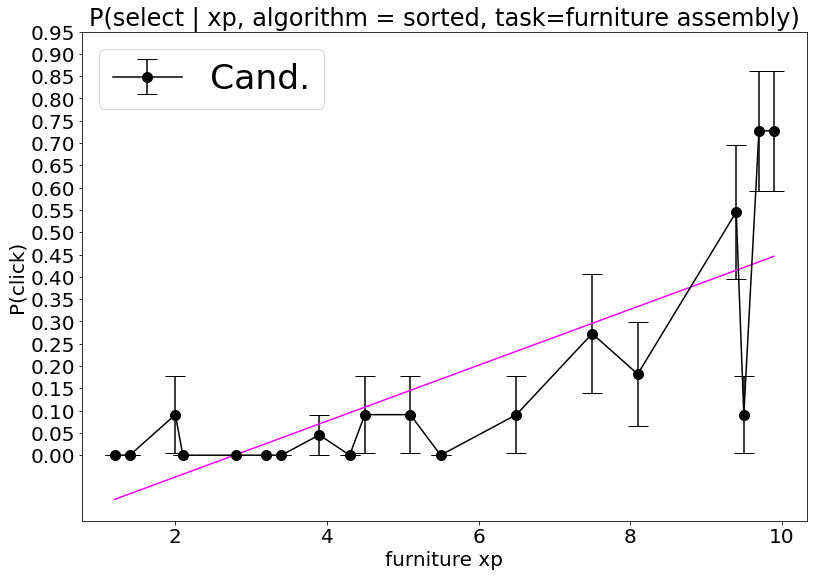

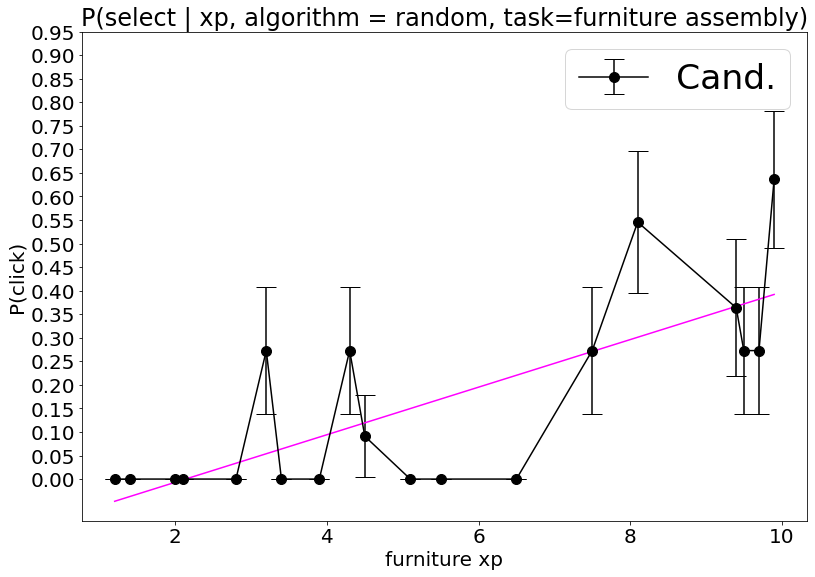

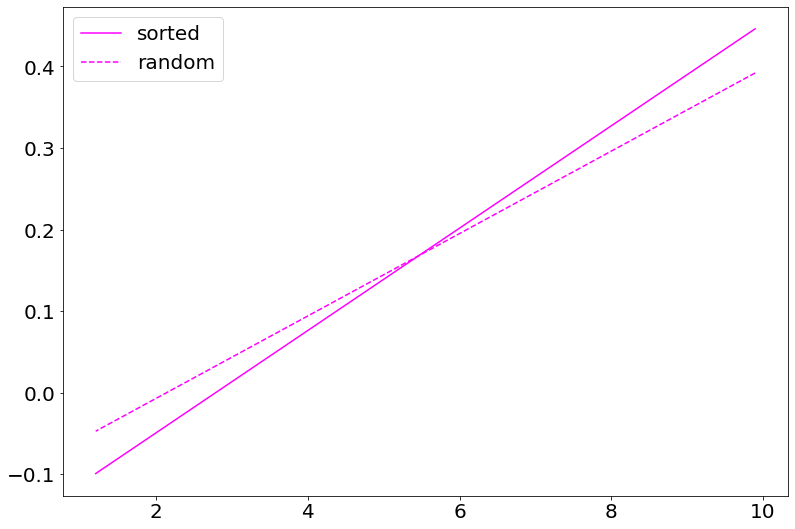

In [77]:
x,n,y, y_pred_sorted = get_p_of_x_condition_xp("furniture", "furniture assembly", random=False)
fig, ax = plt.subplots(figsize=(13,9))
plot_single_dist_with_reg(y,n,y_pred_sorted,"P(select | xp, algorithm = sorted, task=furniture assembly)", ax, x_axis=x, x_title="furniture xp")
plt.show()
x,n,y, y_pred_random = get_p_of_x_condition_xp("furniture", "furniture assembly")
fig, ax = plt.subplots(figsize=(13,9))
plot_single_dist_with_reg(y,n,y_pred_random,"P(select | xp, algorithm = random, task=furniture assembly)", ax, x_axis=x, x_title="furniture xp")
plt.show()
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(x,y_pred_sorted, color ="magenta", label="sorted")
ax.plot(x,y_pred_random, color ="magenta", linestyle="--", label = "random")
ax.legend()
plt.show()

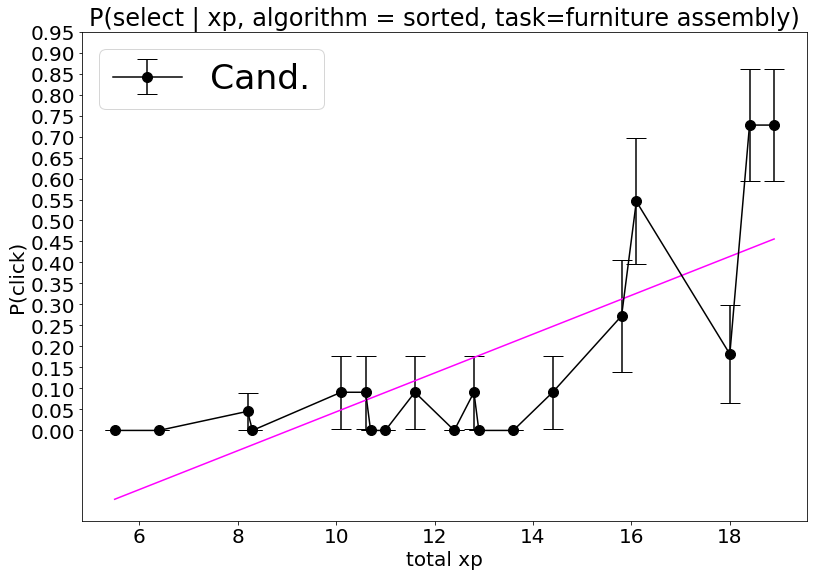

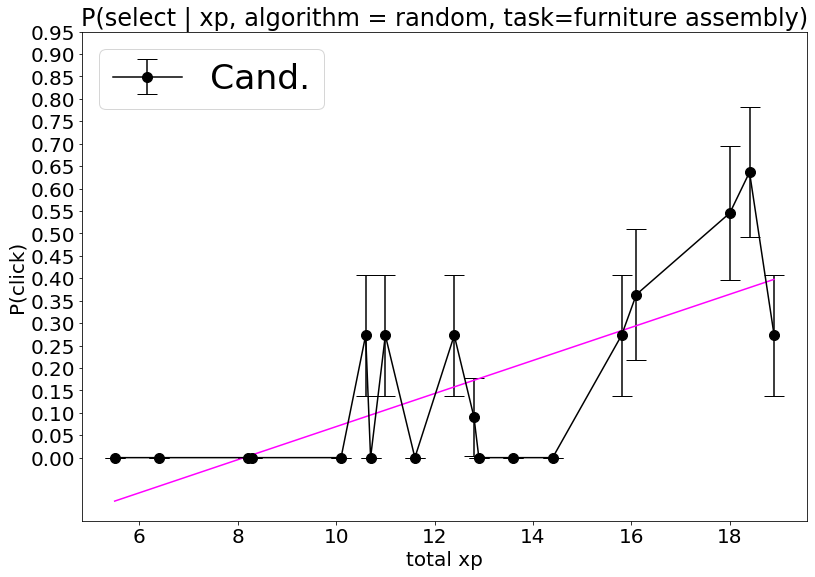

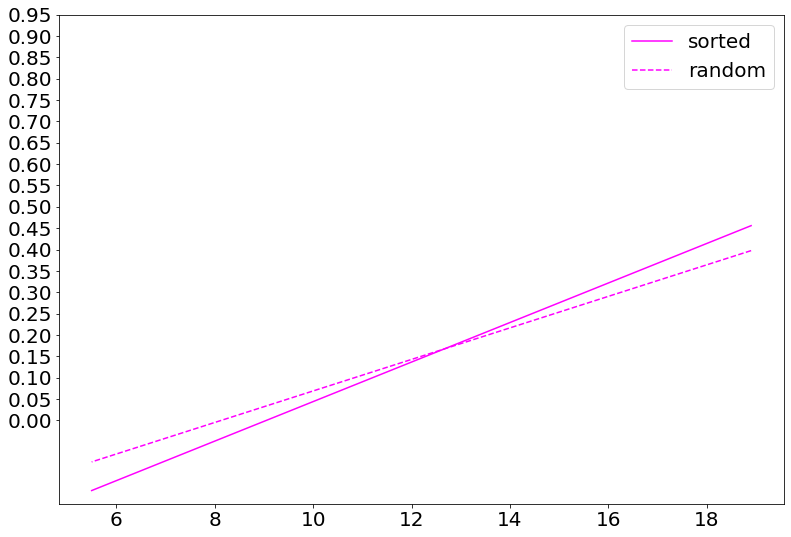

In [78]:
x,n,y, y_pred_sorted = get_p_of_x_condition_xp("total", "furniture assembly", random=False)
fig, ax = plt.subplots(figsize=(13,9))
plot_single_dist_with_reg(y,n,y_pred_sorted,"P(select | xp, algorithm = sorted, task=furniture assembly)", ax, x_axis=x, x_title="total xp")
plt.show()
x,n,y, y_pred_random = get_p_of_x_condition_xp("total", "furniture assembly")
fig, ax = plt.subplots(figsize=(13,9))
plot_single_dist_with_reg(y,n,y_pred_random,"P(select | xp, algorithm = random, task=furniture assembly)", ax, x_axis=x, x_title="total xp")
plt.show()
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(x,y_pred_sorted, color ="magenta", label="sorted")
ax.plot(x,y_pred_random, color ="magenta", linestyle="--", label = "random")
ax.set_yticks(np.arange(0, 1, 0.05))
ax.legend()
plt.show()

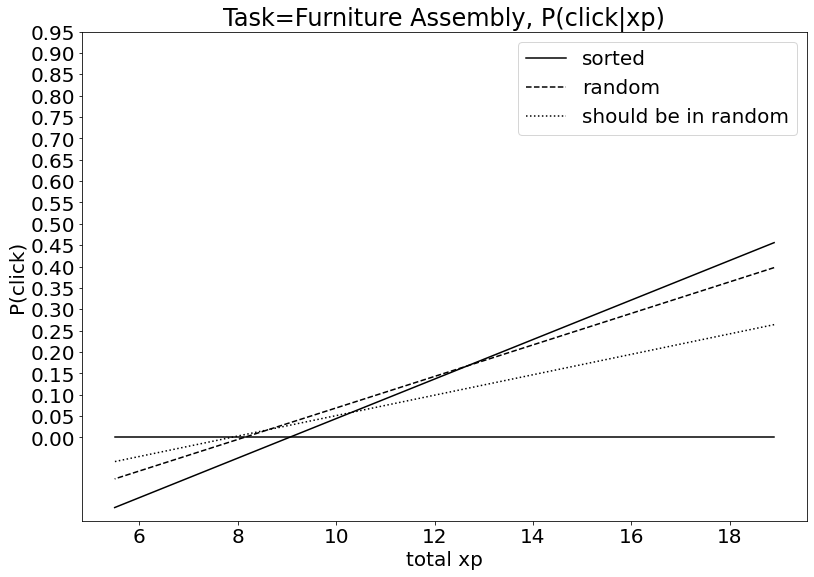

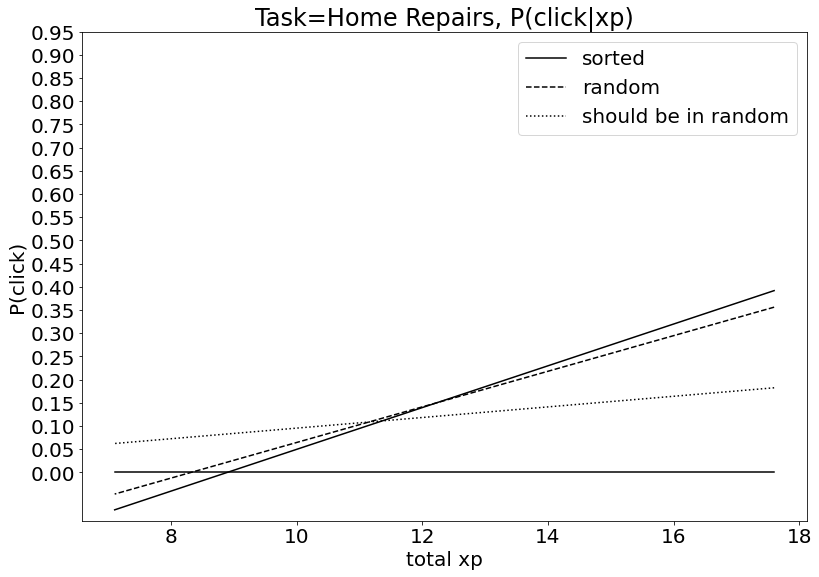

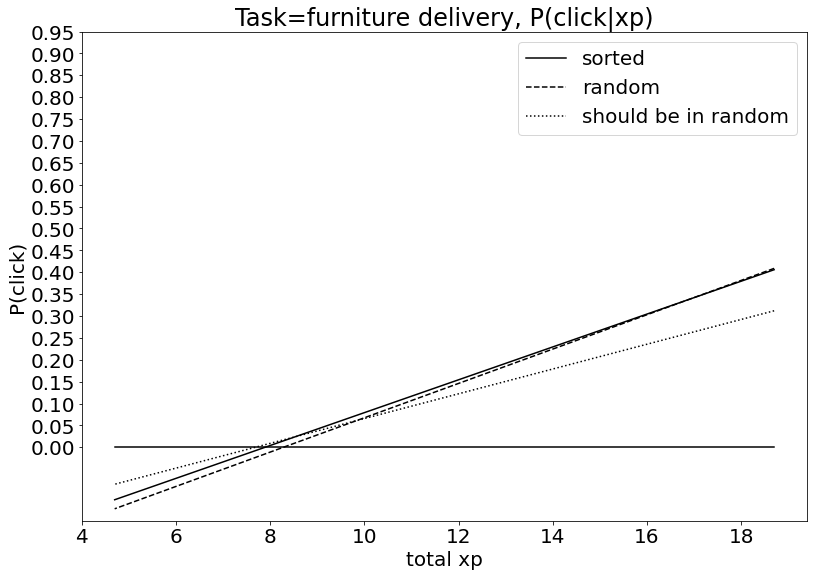

In [75]:
totaldata = [
    {
      "id": 0,
      "tag1": 9.9,
      "tag2": 8.5,
      "totalExp": 18.4,
      "name": "Candidate 1",
      "gender": "f",
      "score": 10.0,
      "score_rank": 1,
      "xp_ranking": 2,
      "totalRank": 7
    },
    {
      "id": 1,
      "tag1": 7.5,
      "tag2": 8.3,
      "totalExp": 15.8,
      "name": "Candidate 2",
      "gender": "f",
      "score": 9.9,
      "score_rank": 3,
      "xp_ranking": 5,
      "totalRank": 2
    },
    {
      "id": 2,
      "tag1": 9.5,
      "tag2": 1.1,
      "totalExp": 10.6,
      "name": "Candidate 3",
      "gender": "f",
      "score": 9.8,
      "score_rank": 5,
      "xp_ranking": 14,
      "totalRank": 4
    },
    {
      "id": 3,
      "tag1": 3.9,
      "tag2": 7.7,
      "totalExp": 11.6,
      "name": "Candidate 4",
      "gender": "f",
      "score": 9.7,
      "score_rank": 7,
      "xp_ranking": 11,
      "totalRank": 6
    },
    {
      "id": 4,
      "tag1": 6.5,
      "tag2": 7.9,
      "totalExp": 14.4,
      "name": "Candidate 5",
      "gender": "f",
      "score": 9.6,
      "score_rank": 9,
      "xp_ranking": 6,
      "totalRank": 15
    },
    {
      "id": 5,
      "tag1": 5.5,
      "tag2": 8.1,
      "totalExp": 13.6,
      "name": "Candidate 6",
      "gender": "f",
      "score": 9.5,
      "score_rank": 11,
      "xp_ranking": 7,
      "totalRank": 8
    },
    {
      "id": 6,
      "tag1": 8.1,
      "tag2": 9.9,
      "totalExp": 18.0,
      "name": "Candidate 7",
      "gender": "f",
      "score": 9.4,
      "score_rank": 13,
      "xp_ranking": 3,
      "totalRank": 5
    },
    {
      "id": 7,
      "tag1": 1.4,
      "tag2": 4.1,
      "totalExp": 5.5,
      "name": "Candidate 8",
      "gender": "f",
      "score": 9.3,
      "score_rank": 15,
      "xp_ranking": 20,
      "totalRank": 14
    },
    {
      "id": 8,
      "tag1": 9.7,
      "tag2": 9.2,
      "totalExp": 18.9,
      "name": "Candidate 9",
      "gender": "f",
      "score": 9.2,
      "score_rank": 17,
      "xp_ranking": 1,
      "totalRank": 12
    },
    {
      "id": 9,
      "tag1": 5.1,
      "tag2": 5.0,
      "totalExp": 10.1,
      "name": "Candidate 10",
      "gender": "f",
      "score": 9.1,
      "score_rank": 19,
      "xp_ranking": 15,
      "totalRank": 18
    },
    {
      "id": 10,
      "tag1": 9.4,
      "tag2": 6.7,
      "totalExp": 16.1,
      "name": "Candidate 11",
      "gender": "m",
      "score": 10.0,
      "score_rank": 2,
      "xp_ranking": 4,
      "totalRank": 11
    },
    {
      "id": 11,
      "tag1": 4.5,
      "tag2": 8.3,
      "totalExp": 12.8,
      "name": "Candidate 12",
      "gender": "m",
      "score": 9.9,
      "score_rank": 4,
      "xp_ranking": 9,
      "totalRank": 19
    },
    {
      "id": 12,
      "tag1": 2.8,
      "tag2": 7.9,
      "totalExp": 10.7,
      "name": "Candidate 13",
      "gender": "m",
      "score": 9.8,
      "score_rank": 6,
      "xp_ranking": 13,
      "totalRank": 20
    },
    {
      "id": 13,
      "tag1": 4.3,
      "tag2": 6.7,
      "totalExp": 11.0,
      "name": "Candidate 14",
      "gender": "m",
      "score": 9.7,
      "score_rank": 8,
      "xp_ranking": 12,
      "totalRank": 3
    },
    {
      "id": 14,
      "tag1": 2.1,
      "tag2": 6.1,
      "totalExp": 8.2,
      "name": "Candidate 15",
      "gender": "m",
      "score": 9.6,
      "score_rank": 10,
      "xp_ranking": 17,
      "totalRank": 10
    },
    {
      "id": 15,
      "tag1": 2.0,
      "tag2": 6.2,
      "totalExp": 8.2,
      "name": "Candidate 16",
      "gender": "m",
      "score": 9.5,
      "score_rank": 12,
      "xp_ranking": 18,
      "totalRank": 9
    },
    {
      "id": 16,
      "tag1": 3.4,
      "tag2": 4.9,
      "totalExp": 8.3,
      "name": "Candidate 17",
      "gender": "m",
      "score": 9.4,
      "score_rank": 14,
      "xp_ranking": 16,
      "totalRank": 17
    },
    {
      "id": 17,
      "tag1": 1.2,
      "tag2": 5.2,
      "totalExp": 6.4,
      "name": "Candidate 18",
      "gender": "m",
      "score": 9.3,
      "score_rank": 16,
      "xp_ranking": 19,
      "totalRank": 16
    },
    {
      "id": 18,
      "tag1": 3.9,
      "tag2": 9.0,
      "totalExp": 12.9,
      "name": "Candidate 19",
      "gender": "m",
      "score": 9.2,
      "score_rank": 18,
      "xp_ranking": 8,
      "totalRank": 13
    },
    {
      "id": 19,
      "tag1": 3.2,
      "tag2": 9.2,
      "totalExp": 12.4,
      "name": "Candidate 20",
      "gender": "m",
      "score": 9.1,
      "score_rank": 20,
      "xp_ranking": 10,
      "totalRank": 1
    }
  ]

totaldata = sorted(totaldata, key = lambda i: i['xp_ranking'])
x,n,y_sorted, y_pred_sorted = get_p_of_x_condition_xp("total", "furniture assembly", random=False)
#print(totaldata)
rel_xp_prob = []
for i in range(0,len(totaldata)):
    for j in range(0,len(x)):
        if totaldata[i]["totalExp"] == x[j]:
            xp_rank_tuple = {}
            xp_rank_tuple["xp"] = x[j]
            xp_rank_tuple["rank"] = i+1
            xp_rank_tuple["prob_sorted"] = y_sorted[j]
            xp_rank_tuple["relevance_sorted"] = y_sorted[j]*math.log(i+2,2)
            xp_rank_tuple["prob_in_random_should_be"] = xp_rank_tuple["relevance_sorted"] * (1/math.log(totaldata[i]["totalRank"]+1,2)) 
            rel_xp_prob.append(xp_rank_tuple)
y_pred_random_s = [0]*len(x)
for v in rel_xp_prob:
    for i in range(0,len(x)):
        if v["xp"] == x[i]:
            y_pred_random_s[i] = v["prob_in_random_should_be"]
coef = np.polyfit(x,y_pred_random_s,1)
poly1d_fn = np.poly1d(coef)
y_pred_random_s = poly1d_fn(x)
x,n,y, y_pred_sorted = get_p_of_x_condition_xp("total", "furniture assembly", random=False)
x,n,y, y_pred_random = get_p_of_x_condition_xp("total", "furniture assembly")
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(x,y_pred_sorted, color ="black", label="sorted")
ax.plot(x,y_pred_random, color ="black", linestyle="--", label = "random")
ax.plot(x,y_pred_random_s, color ="black", linestyle = ":", label = "should be in random")
ax.plot(x,[0]*len(y), color="black")
ax.set_yticks(np.arange(0, 1, 0.05))
ax.set_xlabel("total xp")
ax.set_ylabel("P(click)")
ax.set_title("Task=Furniture Assembly, P(click|xp)")
ax.legend()
plt.show()
totaldata = [
    {
      "id": 0,
      "tag1": 6.8,
      "tag2": 7.4,
      "totalExp": 14.2,
      "name": "Candidate 1",
      "gender": "f",
      "score": 10.0,
      "score_rank": 1,
      "xp_ranking": 5,
      "totalRank": 3
    },
    {
      "id": 1,
      "tag1": 3.9,
      "tag2": 9.0,
      "totalExp": 12.9,
      "name": "Candidate 2",
      "gender": "f",
      "score": 9.9,
      "score_rank": 3,
      "xp_ranking": 9,
      "totalRank": 5
    },
    {
      "id": 2,
      "tag1": 5.7,
      "tag2": 8.6,
      "totalExp": 14.3,
      "name": "Candidate 3",
      "gender": "f",
      "score": 9.8,
      "score_rank": 5,
      "xp_ranking": 4,
      "totalRank": 14
    },
    {
      "id": 3,
      "tag1": 5.0,
      "tag2": 8.9,
      "totalExp": 13.9,
      "name": "Candidate 4",
      "gender": "f",
      "score": 9.7,
      "score_rank": 7,
      "xp_ranking": 6,
      "totalRank": 10
    },
    {
      "id": 4,
      "tag1": 9.7,
      "tag2": 6.1,
      "totalExp": 15.8,
      "name": "Candidate 5",
      "gender": "f",
      "score": 9.6,
      "score_rank": 9,
      "xp_ranking": 3,
      "totalRank": 9
    },
    {
      "id": 5,
      "tag1": 5.7,
      "tag2": 2.0,
      "totalExp": 7.7,
      "name": "Candidate 6",
      "gender": "f",
      "score": 9.5,
      "score_rank": 11,
      "xp_ranking": 19,
      "totalRank": 6
    },
    {
      "id": 6,
      "tag1": 8.3,
      "tag2": 8.1,
      "totalExp": 16.4,
      "name": "Candidate 7",
      "gender": "f",
      "score": 9.4,
      "score_rank": 13,
      "xp_ranking": 2,
      "totalRank": 11
    },
    {
      "id": 7,
      "tag1": 8.4,
      "tag2": 9.2,
      "totalExp": 17.6,
      "name": "Candidate 8",
      "gender": "f",
      "score": 9.3,
      "score_rank": 15,
      "xp_ranking": 1,
      "totalRank": 13
    },
    {
      "id": 8,
      "tag1": 7.1,
      "tag2": 4.7,
      "totalExp": 11.8,
      "name": "Candidate 9",
      "gender": "f",
      "score": 9.2,
      "score_rank": 17,
      "xp_ranking": 13,
      "totalRank": 16
    },
    {
      "id": 9,
      "tag1": 8.3,
      "tag2": 3.9,
      "totalExp": 12.2,
      "name": "Candidate 10",
      "gender": "f",
      "score": 9.1,
      "score_rank": 19,
      "xp_ranking": 11,
      "totalRank": 15
    },
    {
      "id": 10,
      "tag1": 6.4,
      "tag2": 5.0,
      "totalExp": 11.4,
      "name": "Candidate 11",
      "gender": "m",
      "score": 10.0,
      "score_rank": 2,
      "xp_ranking": 14,
      "totalRank": 1
    },
    {
      "id": 11,
      "tag1": 7.6,
      "tag2": 6.1,
      "totalExp": 13.7,
      "name": "Candidate 12",
      "gender": "m",
      "score": 9.9,
      "score_rank": 4,
      "xp_ranking": 7,
      "totalRank": 12
    },
    {
      "id": 12,
      "tag1": 8.9,
      "tag2": 1.6,
      "totalExp": 10.5,
      "name": "Candidate 13",
      "gender": "m",
      "score": 9.8,
      "score_rank": 6,
      "xp_ranking": 15,
      "totalRank": 20
    },
    {
      "id": 13,
      "tag1": 1.5,
      "tag2": 6.3,
      "totalExp": 7.8,
      "name": "Candidate 14",
      "gender": "m",
      "score": 9.7,
      "score_rank": 8,
      "xp_ranking": 18,
      "totalRank": 17
    },
    {
      "id": 14,
      "tag1": 8.5,
      "tag2": 3.6,
      "totalExp": 12.1,
      "name": "Candidate 15",
      "gender": "m",
      "score": 9.6,
      "score_rank": 10,
      "xp_ranking": 12,
      "totalRank": 4
    },
    {
      "id": 15,
      "tag1": 4.6,
      "tag2": 4.8,
      "totalExp": 9.4,
      "name": "Candidate 16",
      "gender": "m",
      "score": 9.5,
      "score_rank": 12,
      "xp_ranking": 17,
      "totalRank": 7
    },
    {
      "id": 16,
      "tag1": 8.7,
      "tag2": 4.3,
      "totalExp": 13.0,
      "name": "Candidate 17",
      "gender": "m",
      "score": 9.4,
      "score_rank": 14,
      "xp_ranking": 8,
      "totalRank": 8
    },
    {
      "id": 17,
      "tag1": 5.9,
      "tag2": 1.2,
      "totalExp": 7.1,
      "name": "Candidate 18",
      "gender": "m",
      "score": 9.3,
      "score_rank": 16,
      "xp_ranking": 20,
      "totalRank": 19
    },
    {
      "id": 18,
      "tag1": 9.9,
      "tag2": 2.7,
      "totalExp": 12.6,
      "name": "Candidate 19",
      "gender": "m",
      "score": 9.2,
      "score_rank": 18,
      "xp_ranking": 10,
      "totalRank": 18
    },
    {
      "id": 19,
      "tag1": 1.8,
      "tag2": 8.3,
      "totalExp": 10.1,
      "name": "Candidate 20",
      "gender": "m",
      "score": 9.1,
      "score_rank": 20,
      "xp_ranking": 16,
      "totalRank": 2
    }
  ]
totaldata = sorted(totaldata, key = lambda i: i['xp_ranking'])
x,n,y_sorted, y_pred_sorted = get_p_of_x_condition_xp("total", "home repairs", random=False)
#print(totaldata)
rel_xp_prob = []
for i in range(0,len(totaldata)):
    for j in range(0,len(x)):
        if totaldata[i]["totalExp"] == x[j]:
            xp_rank_tuple = {}
            xp_rank_tuple["xp"] = x[j]
            xp_rank_tuple["rank"] = i+1
            xp_rank_tuple["prob_sorted"] = y_sorted[j]
            xp_rank_tuple["relevance_sorted"] = y_sorted[j]*math.log(i+2,2)
            xp_rank_tuple["prob_in_random_should_be"] = xp_rank_tuple["relevance_sorted"] * (1/math.log(totaldata[i]["totalRank"]+1,2)) 
            rel_xp_prob.append(xp_rank_tuple)
y_pred_random_s = [0]*len(x)
for v in rel_xp_prob:
    for i in range(0,len(x)):
        if v["xp"] == x[i]:
            y_pred_random_s[i] = v["prob_in_random_should_be"]
coef = np.polyfit(x,y_pred_random_s,1)
poly1d_fn = np.poly1d(coef)
y_pred_random_s = poly1d_fn(x)
x,n,y, y_pred_sorted = get_p_of_x_condition_xp("total", "home repairs", random=False)
x,n,y, y_pred_random = get_p_of_x_condition_xp("total", "home repairs")
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(x,y_pred_sorted, color ="black", label="sorted")
ax.plot(x,y_pred_random, color ="black", linestyle="--", label = "random")
ax.plot(x,y_pred_random_s, color ="black", linestyle = ":", label = "should be in random")
ax.plot(x,[0]*len(y), color="black")
ax.set_yticks(np.arange(0, 1, 0.05))
ax.set_xlabel("total xp")
ax.set_ylabel("P(click)")
ax.set_title("Task=Home Repairs, P(click|xp)")
ax.legend()
plt.show()
totaldata = [
    {
      "id": 0,
      "tag1": 9.1,
      "tag2": 9.6,
      "totalExp": 18.7,
      "name": "Candidate 1",
      "gender": "f",
      "score": 10.0,
      "score_rank": 1,
      "xp_ranking": 1,
      "totalRank": 1
    },
    {
      "id": 1,
      "tag1": 5.5,
      "tag2": 7.6,
      "totalExp": 13.1,
      "name": "Candidate 2",
      "gender": "f",
      "score": 9.9,
      "score_rank": 3,
      "xp_ranking": 11,
      "totalRank": 20
    },
    {
      "id": 2,
      "tag1": 7.6,
      "tag2": 3.6,
      "totalExp": 11.2,
      "name": "Candidate 3",
      "gender": "f",
      "score": 9.8,
      "score_rank": 5,
      "xp_ranking": 12,
      "totalRank": 9
    },
    {
      "id": 3,
      "tag1": 7.0,
      "tag2": 1.2,
      "totalExp": 8.2,
      "name": "Candidate 4",
      "gender": "f",
      "score": 9.7,
      "score_rank": 7,
      "xp_ranking": 16,
      "totalRank": 19
    },
    {
      "id": 4,
      "tag1": 4.9,
      "tag2": 8.7,
      "totalExp": 13.6,
      "name": "Candidate 5",
      "gender": "f",
      "score": 9.6,
      "score_rank": 9,
      "xp_ranking": 10,
      "totalRank": 3
    },
    {
      "id": 5,
      "tag1": 8.6,
      "tag2": 8.2,
      "totalExp": 16.8,
      "name": "Candidate 6",
      "gender": "f",
      "score": 9.5,
      "score_rank": 11,
      "xp_ranking": 4,
      "totalRank": 12
    },
    {
      "id": 6,
      "tag1": 5.3,
      "tag2": 9.3,
      "totalExp": 14.6,
      "name": "Candidate 7",
      "gender": "f",
      "score": 9.4,
      "score_rank": 13,
      "xp_ranking": 7,
      "totalRank": 14
    },
    {
      "id": 7,
      "tag1": 8.8,
      "tag2": 9.0,
      "totalExp": 17.8,
      "name": "Candidate 8",
      "gender": "f",
      "score": 9.3,
      "score_rank": 15,
      "xp_ranking": 2,
      "totalRank": 7
    },
    {
      "id": 8,
      "tag1": 2.5,
      "tag2": 3.9,
      "totalExp": 6.4,
      "name": "Candidate 9",
      "gender": "f",
      "score": 9.2,
      "score_rank": 17,
      "xp_ranking": 19,
      "totalRank": 10
    },
    {
      "id": 9,
      "tag1": 9.9,
      "tag2": 6.4,
      "totalExp": 16.3,
      "name": "Candidate 10",
      "gender": "f",
      "score": 9.1,
      "score_rank": 19,
      "xp_ranking": 5,
      "totalRank": 18
    },
    {
      "id": 10,
      "tag1": 1.6,
      "tag2": 5.0,
      "totalExp": 6.6,
      "name": "Candidate 11",
      "gender": "m",
      "score": 10.0,
      "score_rank": 2,
      "xp_ranking": 17,
      "totalRank": 16
    },
    {
      "id": 11,
      "tag1": 8.3,
      "tag2": 7.7,
      "totalExp": 16.0,
      "name": "Candidate 12",
      "gender": "m",
      "score": 9.9,
      "score_rank": 4,
      "xp_ranking": 6,
      "totalRank": 11
    },
    {
      "id": 12,
      "tag1": 6.3,
      "tag2": 7.9,
      "totalExp": 14.2,
      "name": "Candidate 13",
      "gender": "m",
      "score": 9.8,
      "score_rank": 6,
      "xp_ranking": 8,
      "totalRank": 8
    },
    {
      "id": 13,
      "tag1": 7.3,
      "tag2": 9.5,
      "totalExp": 16.8,
      "name": "Candidate 14",
      "gender": "m",
      "score": 9.7,
      "score_rank": 8,
      "xp_ranking": 3,
      "totalRank": 2
    },
    {
      "id": 14,
      "tag1": 6.1,
      "tag2": 3.5,
      "totalExp": 9.6,
      "name": "Candidate 15",
      "gender": "m",
      "score": 9.6,
      "score_rank": 10,
      "xp_ranking": 14,
      "totalRank": 6
    },
    {
      "id": 15,
      "tag1": 6.3,
      "tag2": 3.4,
      "totalExp": 9.7,
      "name": "Candidate 16",
      "gender": "m",
      "score": 9.5,
      "score_rank": 12,
      "xp_ranking": 13,
      "totalRank": 4
    },
    {
      "id": 16,
      "tag1": 5.5,
      "tag2": 8.7,
      "totalExp": 14.2,
      "name": "Candidate 17",
      "gender": "m",
      "score": 9.4,
      "score_rank": 14,
      "xp_ranking": 9,
      "totalRank": 15
    },
    {
      "id": 17,
      "tag1": 4.7,
      "tag2": 1.7,
      "totalExp": 6.4,
      "name": "Candidate 18",
      "gender": "m",
      "score": 9.3,
      "score_rank": 16,
      "xp_ranking": 18,
      "totalRank": 5
    },
    {
      "id": 18,
      "tag1": 6.7,
      "tag2": 2.6,
      "totalExp": 9.3,
      "name": "Candidate 19",
      "gender": "m",
      "score": 9.2,
      "score_rank": 18,
      "xp_ranking": 15,
      "totalRank": 13
    },
    {
      "id": 19,
      "tag1": 2.8,
      "tag2": 1.9,
      "totalExp": 4.7,
      "name": "Candidate 20",
      "gender": "m",
      "score": 9.1,
      "score_rank": 20,
      "xp_ranking": 20,
      "totalRank": 17
    }
  ]
totaldata = sorted(totaldata, key = lambda i: i['xp_ranking'])
x,n,y_sorted, y_pred_sorted = get_p_of_x_condition_xp("total", "furniture delivery", random=False)
#print(totaldata)
rel_xp_prob = []
for i in range(0,len(totaldata)):
    for j in range(0,len(x)):
        if totaldata[i]["totalExp"] == x[j]:
            xp_rank_tuple = {}
            xp_rank_tuple["xp"] = x[j]
            xp_rank_tuple["rank"] = i+1
            xp_rank_tuple["prob_sorted"] = y_sorted[j]
            xp_rank_tuple["relevance_sorted"] = y_sorted[j]*math.log(i+2,2)
            xp_rank_tuple["prob_in_random_should_be"] = xp_rank_tuple["relevance_sorted"] * (1/math.log(totaldata[i]["totalRank"]+1,2)) 
            rel_xp_prob.append(xp_rank_tuple)
y_pred_random_s = [0]*len(x)
for v in rel_xp_prob:
    for i in range(0,len(x)):
        if v["xp"] == x[i]:
            y_pred_random_s[i] = v["prob_in_random_should_be"]
coef = np.polyfit(x,y_pred_random_s,1)
poly1d_fn = np.poly1d(coef)
y_pred_random_s = poly1d_fn(x)
x,n,y, y_pred_sorted = get_p_of_x_condition_xp("total", "furniture delivery", random=False)
x,n,y, y_pred_random = get_p_of_x_condition_xp("total", "furniture delivery")
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(x,y_pred_sorted, color ="black", label="sorted")
ax.plot(x,y_pred_random, color ="black", linestyle="--", label = "random")
ax.plot(x,y_pred_random_s, color ="black", linestyle = ":", label = "should be in random")
ax.plot(x,[0]*len(y), color="black")
ax.set_yticks(np.arange(0, 1, 0.05))
ax.set_xlabel("total xp")
ax.set_ylabel("P(click)")
ax.set_title("Task=furniture delivery, P(click|xp)")
ax.legend()
plt.show()